<a href="https://colab.research.google.com/github/Cecelia1122/Speech_LLM/blob/main/notebooks_SpeechLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo: Speech-to-Speech Translation using LLM

This notebook runs three speech pipelines end-to-end on Google Colab:


- Approach A (fast, English-only target): Speech → Whisper (task=translate) → English text → English TTS (SpeechT5)
- Approach B (multilingual, quality): Speech → Whisper (ASR) → MT (M2M100) → TTS (English: SpeechT5; non‑English: Edge‑TTS)
- Approach C (end‑to‑end S2ST): SeamlessM4T direct Speech‑to‑Speech




### Part 1 — Project bootstrap and environment configuration

#### 1. Runtime setup and paths
- Defines PATHS (inputs, outputs, manifests, caches), seeds, and basic flags so downstream code has a consistent filesystem layout.
- Creates required directories on disk and, if present, wires in Colab-specific helpers.
#### 2. Google Drive
If SAVE_TO_DRIVE is True:
- Mount Drive
- Set Hugging Face cache (HF_HOME) to a folder on Drive
- Create project folders for inputs and outputs

This prevents the VM disk from filling up and keeps assets persistent between sessions.

#### 3. Package installation/validation
- Installs and verifies versions for faster-whisper, transformers, soundfile, sentencepiece, torchaudio, and optional extras needed later.
- Confirms libsndfile works with soundfile for reading/writing WAVs.

In [2]:
# User-configurable settings (safe to edit)
SAVE_TO_DRIVE = True           # Use Google Drive for HF cache and outputs
USE_MIC = True                 # Enable the in-notebook microphone recorder UI

RUN_PIPELINE_A = True          # Approach A: Speech -> Whisper translate -> English TTS
RUN_PIPELINE_B = True          # Approach B: Speech -> ASR -> MT -> TTS
RUN_PIPELINE_C = False         # Approach C: SeamlessM4T S2ST (optional)

WHISPER_SIZE = "large-v2"      # Options: "large-v2" (default), "medium"
MT_CHOICE = "nllb"             # Options: "nllb" (default), "opus"
TTS_EN = "speecht5"            # Options: "speecht5" (default), "parler"
TTS_NONEN = "mms"              # Options: "mms" (default)

# Language configuration examples (edit per file later in the manifest UI)
DEFAULT_SRC_LANG = "auto"      # e.g., "en", "de", "es", "zh", "ar" or "auto"
DEFAULT_TGT_LANG_TEXT = "eng_Latn"  # NLLB target code, e.g., "eng_Latn", "deu_Latn", "spa_Latn"
DEFAULT_TGT_LANG_TTS = "en"     # TTS target code, e.g., "en", "de", "es", "zh", "ar"

# Advanced (leave as-is for now)
MAX_AUDIO_SECONDS = 60          # Warn/advise chunking above this duration
SEAMLESS_AVAILABLE = False      # Will be probed later if C is enabled
PROJECT_NAME = "Speech AI on Colab — All-in-One"
print("Configuration loaded.")

Configuration loaded.


In [3]:
# Google drive set
import os, shutil, sys, subprocess, textwrap
HF_HOME = None
BASE_DIR = "/content"
DRIVE_BASE = "/content/drive/MyDrive/speech_ai_colab"
PATHS = {}

if SAVE_TO_DRIVE:
    try:
        from google.colab import drive  # type: ignore
        drive.mount('/content/drive', force_remount=False)
        os.makedirs(DRIVE_BASE, exist_ok=True)
        HF_HOME = os.path.join(DRIVE_BASE, "hf_cache")
        os.environ["HF_HOME"] = HF_HOME
        for p in ["inputs", "recordings", "outputs", "manifests", "results", "figures"]:
            os.makedirs(os.path.join(DRIVE_BASE, p), exist_ok=True)
        PATHS = {
            "inputs": os.path.join(DRIVE_BASE, "inputs"),
            "recordings": os.path.join(DRIVE_BASE, "recordings"),
            "outputs": os.path.join(DRIVE_BASE, "outputs"),
            "manifests": os.path.join(DRIVE_BASE, "manifests"),
            "results": os.path.join(DRIVE_BASE, "results"),
            "figures": os.path.join(DRIVE_BASE, "figures"),
        }
        print("Drive mounted. HF_HOME:", HF_HOME)
    except Exception as e:
        print("Drive not available, continuing on VM:", e)
        SAVE_TO_DRIVE = False

if not SAVE_TO_DRIVE:
    for p in ["inputs", "recordings", "outputs", "manifests", "results", "figures"]:
        os.makedirs(os.path.join(BASE_DIR, p), exist_ok=True)
    PATHS = {
        "inputs": os.path.join(BASE_DIR, "inputs"),
        "recordings": os.path.join(BASE_DIR, "recordings"),
        "outputs": os.path.join(BASE_DIR, "outputs"),
        "manifests": os.path.join(BASE_DIR, "manifests"),
        "results": os.path.join(BASE_DIR, "results"),
        "figures": os.path.join(BASE_DIR, "figures"),
    }
    print("Using VM storage. Outputs will be ephemeral.")

print("Project paths:")
for k, v in PATHS.items():
    print(f"- {k}: {v}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted. HF_HOME: /content/drive/MyDrive/speech_ai_colab/hf_cache
Project paths:
- inputs: /content/drive/MyDrive/speech_ai_colab/inputs
- recordings: /content/drive/MyDrive/speech_ai_colab/recordings
- outputs: /content/drive/MyDrive/speech_ai_colab/outputs
- manifests: /content/drive/MyDrive/speech_ai_colab/manifests
- results: /content/drive/MyDrive/speech_ai_colab/results
- figures: /content/drive/MyDrive/speech_ai_colab/figures


In [4]:
#Core deps (system + Python) — Colab Python 3.12, CUDA GPU
import os, subprocess, sys

print("[Deps] Installing system tools (ffmpeg) ...")
subprocess.run(["bash", "-lc", "apt -qq update && apt -qq install -y ffmpeg"], check=False)

print("[Deps] Upgrading pip/setuptools/wheel ...")
subprocess.run([sys.executable, "-m", "pip", "install", "-U", "pip", "setuptools", "wheel"], check=True)

core_packages = [
    # Core model/tooling
    "transformers>=4.42.0",
    "accelerate>=0.30.0",
    "faster-whisper>=1.0.0",      # includes ctranslate2
    "sentencepiece>=0.1.99",
    "sacremoses",
    "huggingface_hub>=0.23.0",

    # Audio + preprocessing
    "soundfile",
    "scipy>=1.10",

    # UI + eval
    "gradio>=4.0.0",
    "evaluate>=0.4.1",
    "sacrebleu>=2.4.0",
    "jiwer>=3.0.0",
    "pandas",
    "tqdm",

    # A/B/C extras
    "einops",            # Approach A uses this via transformers layers
    "edge-tts",          # Approach B non-English TTS
    "pydub",             # Approach B MP3 decode (uses ffmpeg)
    "langdetect",        # Approach B optional language fallback
    "nest-asyncio",      # Approach B async fallback helper
]

print("[Deps] Installing core Python packages ...")
subprocess.run([sys.executable, "-m", "pip", "install", "-U"] + core_packages, check=True)

# Torchaudio: try to match the preinstalled Torch to avoid CUDA mismatches
def install_torchaudio_matching_torch():
    try:
        import torch
        torch_ver = torch.__version__
        print(f"[Deps] Detected torch {torch_ver}")
        cu = getattr(torch.version, "cuda", None)
        if cu:
            cu_tag = "cu" + cu.replace(".", "")
            print(f"[Deps] Installing torchaudio=={torch_ver} from cu index ({cu_tag}) ...")
            cmd = [sys.executable, "-m", "pip", "install", "-U",
                   f"torchaudio=={torch_ver}",
                   "--index-url", f"https://download.pytorch.org/whl/{cu_tag}"]
        else:
            print(f"[Deps] CPU build detected, installing torchaudio=={torch_ver} from PyPI ...")
            cmd = [sys.executable, "-m", "pip", "install", "-U", f"torchaudio=={torch_ver}"]
        subprocess.run(cmd, check=True)
    except Exception as e:
        print("[Deps][WARN] Could not match-install torchaudio to torch:", e)
        print("[Deps] Falling back to plain torchaudio install from PyPI ...")
        try:
            subprocess.run([sys.executable, "-m", "pip", "install", "-U", "torchaudio"], check=True)
        except Exception as e2:
            print("[Deps][ERROR] torchaudio install failed:", e2)

install_torchaudio_matching_torch()

# Install encodec after torchaudio to avoid wheel churn
print("[Deps] Installing encodec ...")
subprocess.run([sys.executable, "-m", "pip", "install", "-U", "encodec"], check=True)

# Nice-to-have defaults
os.environ["TOKENIZERS_PARALLELISM"] = "false"

print("[Deps] Core dependencies installed.")
DEPS_INSTALLED = True

[Deps] Installing system tools (ffmpeg) ...
[Deps] Upgrading pip/setuptools/wheel ...
[Deps] Installing core Python packages ...
[Deps] Detected torch 2.8.0+cu126
[Deps] Installing torchaudio==2.8.0+cu126 from cu index (cu126) ...
[Deps] Installing encodec ...
[Deps] Core dependencies installed.


In [5]:
# Verify imports and environment
import platform, importlib, shutil, os

print("=== Environment ===")
try:
    import torch
    print("Python:", platform.python_version())
    print("PyTorch:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU:", torch.cuda.get_device_name(0))
except Exception as e:
    print("[Verify][WARN] Torch import failed:", e)

for pkg in ["transformers", "accelerate", "faster_whisper", "sentencepiece",
            "soundfile", "scipy", "gradio", "evaluate", "sacrebleu", "jiwer", "torchaudio"]:
    try:
        m = importlib.import_module(pkg.replace("-", "_"))
        ver = getattr(m, "__version__", "(no __version__)")
        print(f"{pkg}: {ver}")
    except Exception as e:
        print(f"[Verify][WARN] {pkg}: not importable -> {e}")

# Show HF_HOME if set, and disk space
hf_home = os.environ.get("HF_HOME", None)
print("HF_HOME:", hf_home if hf_home else "(not set)")
print("Outputs dir:", PATHS.get("outputs"))
print("===================")

=== Environment ===
Python: 3.12.11
PyTorch: 2.8.0+cu126
CUDA available: False
transformers: 4.56.1
accelerate: 1.10.1
faster_whisper: 1.2.0
sentencepiece: 0.2.1
soundfile: 0.13.1
scipy: 1.16.1
gradio: 5.44.1
evaluate: 0.4.5
sacrebleu: 2.5.1
jiwer: (no __version__)
torchaudio: 2.8.0+cu126
HF_HOME: /content/drive/MyDrive/speech_ai_colab/hf_cache
Outputs dir: /content/drive/MyDrive/speech_ai_colab/outputs


## Part 2 — Data intake and audio preprocessing

- Scan the inputs folder for raw audio files and idempotently creates/updates manifests.
- Automatic resampling to 16 kHz mono and normalization.
- Optional preprocessing when the intake audio is unclear.




In [6]:
# Discover your audio (and optional upload helper)

from pathlib import Path
import os, shutil

inputs_dir = PATHS["inputs"]
os.makedirs(inputs_dir, exist_ok=True)

# If your audios are already in PATHS["inputs"], we just list them:
audio_exts = {".mp3",".wav",".flac",".m4a",".ogg"}
found = [p for p in Path(inputs_dir).glob("**/*") if p.suffix.lower() in audio_exts]
print("Found audio files:")
for p in found:
    print("-", p)

print(f"Total: {len(found)} file(s) in {inputs_dir}")

# Optional: upload from local computer into inputs/
USE_UPLOAD_HELPER = False
if USE_UPLOAD_HELPER:
    try:
        from google.colab import files  # type: ignore
        uploaded = files.upload()
        for name, _ in uploaded.items():
            shutil.move(name, os.path.join(inputs_dir, name))
        print("Uploaded ->", inputs_dir)
    except Exception as e:
        print("[WARN] Upload helper not available:", e)

Found audio files:
- /content/drive/MyDrive/speech_ai_colab/inputs/en.mp3
- /content/drive/MyDrive/speech_ai_colab/inputs/es.mp3
- /content/drive/MyDrive/speech_ai_colab/inputs/de.mp3
- /content/drive/MyDrive/speech_ai_colab/inputs/zh.mp3
- /content/drive/MyDrive/speech_ai_colab/inputs/ar.mp3
- /content/drive/MyDrive/speech_ai_colab/inputs/preproc/en.wav
- /content/drive/MyDrive/speech_ai_colab/inputs/preproc/de.wav
- /content/drive/MyDrive/speech_ai_colab/inputs/preproc/es.wav
- /content/drive/MyDrive/speech_ai_colab/inputs/preproc/ar.wav
- /content/drive/MyDrive/speech_ai_colab/inputs/preproc/zh.wav
Total: 10 file(s) in /content/drive/MyDrive/speech_ai_colab/inputs


In [7]:
# Create/update manifest (idempotent; excludes preproc; tracks src_path)
import pandas as pd, os
from pathlib import Path

MANIFEST_PATH = os.path.join(PATHS["manifests"], "manifest.csv")
os.makedirs(PATHS["manifests"], exist_ok=True)

cols = [
    "id","path","src_path","src_lang","src_transcript",
    "ref_translation_en","ref_translation_tgt","split","license"
]

# Load or create
if os.path.exists(MANIFEST_PATH):
    df = pd.read_csv(MANIFEST_PATH)
    # Back-compat for transcript column name
    if "src_transcript" not in df.columns and "transcript_src" in df.columns:
        df["src_transcript"] = df["transcript_src"]
    for c in cols:
        if c not in df.columns:
            df[c] = ""
else:
    df = pd.DataFrame(columns=cols)

preproc_dir = os.path.join(PATHS["inputs"], "preproc")
audio_exts = {".mp3",".wav",".flac",".m4a",".ogg"}

# Discover raw inputs but EXCLUDE anything under preproc/
found = []
for p in Path(PATHS["inputs"]).rglob("*"):
    if not p.is_file():
        continue
    if p.suffix.lower() not in audio_exts:
        continue
    if str(p).startswith(preproc_dir.rstrip("/")):
        continue
    found.append(p)

# Existing guards
existing_ids = set(str(x) for x in df["id"].astype(str) if str(x))
existing_src = set(str(x) for x in df.get("src_path", pd.Series([], dtype=str)).astype(str) if str(x))
existing_paths = set(str(x) for x in df["path"].astype(str) if str(x))

added = 0
for p in sorted(found):
    sp = str(p)
    fid = p.stem

    # Skip if this id already exists OR either source/preproc path already tracked
    if fid in existing_ids or sp in existing_src or sp in existing_paths:
        continue

    df.loc[len(df)] = {
        "id": fid,
        "path": sp,                 # will be rewritten to preproc WAV in 5.3
        "src_path": sp,             # keep original source path for idempotency
        "src_lang": DEFAULT_SRC_LANG if "DEFAULT_SRC_LANG" in globals() else "auto",
        "src_transcript": "",
        "ref_translation_en": "",
        "ref_translation_tgt": "",
        "split": "demo",
        "license": ""
    }
    existing_ids.add(fid)
    existing_src.add(sp)
    added += 1

df.to_csv(MANIFEST_PATH, index=False)
#print(f"Manifest at {MANIFEST_PATH} — added {added} new row(s), total {len(df)}.")
#display(df.tail(min(5, len(df))))

In [8]:
# clean — drop duplicates created earlier
import pandas as pd, os

MANIFEST_PATH = os.path.join(PATHS["manifests"], "manifest.csv")
df = pd.read_csv(MANIFEST_PATH)

# Ensure expected columns
for c in ["src_path","src_transcript"]:
    if c not in df.columns:
        df[c] = ""

# Prefer to keep the earliest row per id (or change keep to "last" if you prefer latest)
before = len(df)
df = df.drop_duplicates(subset=["id"], keep="first")

# Also guard by src_path if present
if df["src_path"].notna().any():
    df = df.drop_duplicates(subset=["src_path"], keep="first")

df.to_csv(MANIFEST_PATH, index=False)
#print(f"Deduped manifest: {before} -> {len(df)} rows")
#display(df.tail(min(5, len(df))))

In [9]:
# Normalize to 16 kHz mono WAV and update manifest paths (idempotent)
import pandas as pd, os, subprocess
from pathlib import Path

MANIFEST_PATH = os.path.join(PATHS["manifests"], "manifest.csv")
df = pd.read_csv(MANIFEST_PATH)

preproc_dir = os.path.join(PATHS["inputs"], "preproc")
os.makedirs(preproc_dir, exist_ok=True)

# Set True to force re-encode even if outputs already exist
RE_PREPROC = False

def to_wav_16k_mono(src_path: str, out_path: str):
    # Ensure parent dir exists
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    cmd = [
        "bash","-lc",
        f'ffmpeg -y -hide_banner -loglevel error -i "{src_path}" -ac 1 -ar 16000 -vn -map_metadata -1 "{out_path}"'
    ]
    subprocess.run(cmd, check=True)

converted = 0
skipped = 0
errors = 0

# Make sure expected columns exist
if "src_path" not in df.columns:
    df["src_path"] = ""

for i, row in df.iterrows():
    # Prefer original source if available; fallback to current path
    src = row.get("src_path")
    src = src if isinstance(src, str) and os.path.exists(src) and src.strip() else row.get("path")

    if not isinstance(src, str) or not os.path.exists(src):
        print(f"[WARN] Missing source file, skipping: {src}")
        errors += 1
        continue

    # Determine output filename using id if present; else stem of source
    fid = row["id"] if isinstance(row.get("id"), str) and row["id"].strip() else Path(src).stem
    dst = os.path.join(preproc_dir, f"{fid}.wav")

    # If destination already exists and re-preproc is disabled, just point manifest to it
    if (not RE_PREPROC) and os.path.exists(dst) and os.path.getsize(dst) > 44:
        df.at[i, "id"] = fid
        df.at[i, "path"] = dst
        if not df.at[i, "src_path"]:
            df.at[i, "src_path"] = src
        skipped += 1
        continue

    # If source is already the desired destination (rare), skip
    if os.path.abspath(src) == os.path.abspath(dst):
        df.at[i, "id"] = fid
        df.at[i, "path"] = dst
        if not df.at[i, "src_path"]:
            df.at[i, "src_path"] = src
        skipped += 1
        continue

    try:
        to_wav_16k_mono(src, dst)
        df.at[i, "id"] = fid
        df.at[i, "path"] = dst
        if not df.at[i, "src_path"]:
            df.at[i, "src_path"] = src
        converted += 1
    except Exception as e:
        print(f"[WARN] Failed to preprocess {src}: {e}")
        errors += 1

df.to_csv(MANIFEST_PATH, index=False)
#print(f"Preprocessed {converted} file(s), skipped {skipped} existing file(s), errors {errors}.")
#print("Output dir:", preproc_dir)

## Show a quick tail
#try:
#    from IPython.display import display
#    display(df.tail(min(5, len(df))))
#except Exception:
#    pass

In [10]:
# 5.4 — Quick audit and listen
import soundfile as sf
from IPython.display import Audio, display, HTML
import pandas as pd
import math

df = pd.read_csv(MANIFEST_PATH)

def duration(path):
    try:
        with sf.SoundFile(path) as f:
            return len(f) / f.samplerate
    except Exception:
        return None

df["duration_s"] = df["path"].apply(duration)
print(df[["id","src_lang","duration_s","path"]])

# Warn on long clips
try:
    max_len = MAX_AUDIO_SECONDS if "MAX_AUDIO_SECONDS" in globals() else 60
    long_mask = df["duration_s"].apply(lambda x: (x is not None) and (x > max_len))
    long_ids = df.loc[long_mask, "id"].tolist()
    if long_ids:
        print(f"[WARN] {len(long_ids)} file(s) exceed {max_len}s:", ", ".join(long_ids))
except Exception:
    pass

# Listen to the first few files
for _, row in df.head(5).iterrows():
    print(f"\nID — {row['id']} | {row['src_lang']} | {row['duration_s']:.2f}s")
    display(Audio(filename=row["path"]))

   id src_lang  duration_s                                               path
0  ar     auto    5.340000  /content/drive/MyDrive/speech_ai_colab/inputs/...
1  zh     auto    4.380000  /content/drive/MyDrive/speech_ai_colab/inputs/...
2  en     auto    4.519188  /content/drive/MyDrive/speech_ai_colab/inputs/...
3  de     auto    4.290000  /content/drive/MyDrive/speech_ai_colab/inputs/...
4  es     auto    4.597563  /content/drive/MyDrive/speech_ai_colab/inputs/...

ID — ar | auto | 5.34s



ID — zh | auto | 4.38s



ID — en | auto | 4.52s



ID — de | auto | 4.29s



ID — es | auto | 4.60s


In [11]:
# (Optional when input audio is unclear)lite — Only trim/normalize when clearly needed
import os, math
import numpy as np
import soundfile as sf
import pandas as pd

RUN_PREPROC_ENHANCE = False     # set True to enable
TARGET_PEAK_DBFS = -1.0          # normalize target
LOW_PEAK_THRESHOLD_DBFS = -12.0  # only normalize if current peak is below this
TRIM_SILENCE = True
SILENCE_THRESH_DBFS = -40.0
TRIM_PADDING_S = 0.05
MIN_TOTAL_TRIM_S = 1.0           # only write if (lead+tail) exceeds this

MANIFEST_PATH = os.path.join(PATHS["manifests"], "manifest.csv")

def amp_from_dbfs(dbfs): return float(10.0 ** (dbfs / 20.0))
def dbfs_from_amp(amp): return float("-inf") if amp <= 0 else float(20.0 * math.log10(amp))

def frame_rms(x, frame, hop):
    n = len(x)
    if n < frame:
        return np.array([np.sqrt(np.mean(x**2) + 1e-12)], dtype=np.float32)
    n_frames = 1 + max(0, (n - frame) // hop)
    rms = np.empty(n_frames, dtype=np.float32)
    for i in range(n_frames):
        s, e = i * hop, i * hop + frame
        rms[i] = float(np.sqrt(np.mean(x[s:e]**2) + 1e-12))
    return rms

def detect_outer_silence(x, sr, thresh_dbfs, pad_s):
    if x.size == 0:
        return 0, 0
    frame = max(1, int(0.050 * sr))
    hop = max(1, int(0.010 * sr))
    rms = frame_rms(x, frame, hop)
    thresh_amp = amp_from_dbfs(thresh_dbfs)
    voiced = rms >= thresh_amp
    if not np.any(voiced):
        return 0, 0
    first = int(np.argmax(voiced))
    last = int(len(voiced) - 1 - np.argmax(voiced[::-1]))
    pad = int(pad_s * sr)
    start_sample = max(0, first * hop - pad)
    end_sample = min(len(x), last * hop + frame + pad)
    lead = start_sample
    tail = len(x) - end_sample
    return lead, tail

def peak_normalize(x, target_dbfs):
    peak = float(np.max(np.abs(x))) if x.size else 0.0
    if peak <= 0.0:
        return x, dbfs_from_amp(peak), 0.0
    target_amp = amp_from_dbfs(target_dbfs)
    gain = target_amp / peak
    y = np.clip(x * gain, -1.0, 1.0)
    return y.astype(np.float32), dbfs_from_amp(peak), dbfs_from_amp(abs(gain))

if not RUN_PREPROC_ENHANCE:
    print("6.1-lite disabled (RUN_PREPROC_ENHANCE=False). Skipping.")
else:
    df = pd.read_csv(MANIFEST_PATH)
    changed = 0
    for _, row in df.iterrows():
        p = str(row.get("path", ""))
        if not p or not os.path.isfile(p) or not p.lower().endswith(".wav"):
            continue
        try:
            y, sr = sf.read(p, dtype="float32", always_2d=False)
            if getattr(y, "ndim", 1) == 2:
                y = y.mean(axis=1)
            # Decide actions based on thresholds
            lead, tail = detect_outer_silence(y, sr, SILENCE_THRESH_DBFS, TRIM_PADDING_S) if TRIM_SILENCE else (0, 0)
            total_trim_s = (lead + tail) / float(sr)
            peak_dbfs = dbfs_from_amp(float(np.max(np.abs(y))) if y.size else 0.0)

            do_trim = total_trim_s >= MIN_TOTAL_TRIM_S
            do_norm = peak_dbfs < LOW_PEAK_THRESHOLD_DBFS

            if not (do_trim or do_norm):
                continue

            if do_trim:
                start = lead
                end = len(y) - tail
                y = y[start:end]

            if do_norm:
                y, before_peak_db, gain_db = peak_normalize(y, TARGET_PEAK_DBFS)
            else:
                before_peak_db = peak_dbfs
                gain_db = 0.0

            sf.write(p, y, sr, subtype="PCM_16")
            print(f"[6.1-lite] {row.get('id','(no id)')} | trim={total_trim_s:.2f}s | peak {before_peak_db:.1f}dBFS -> {dbfs_from_amp(float(np.max(np.abs(y)) or 0.0)):.1f}dBFS | gain {gain_db:+.1f}dB")
            changed += 1
        except Exception as e:
            print(f"[6.1-lite][ERR] {row.get('id','(no id)')}: {e}")
    print(f"6.1-lite complete. Modified {changed} file(s).")
    import pandas as pd

    #Preview the proessed audios
    from IPython.display import Audio, display

    df = pd.read_csv(MANIFEST_PATH)
    print(df[["id","src_lang","path"]].tail(min(5, len(df))))

    for _, row in df.tail(min(5, len(df))).iterrows():
        print(f"\n{row['id']} — {row['path']}")
        try:
            display(Audio(filename=row["path"]))
        except Exception as e:
            print("[Audio preview error]", e)

6.1-lite disabled (RUN_PREPROC_ENHANCE=False). Skipping.


## Part 3 —  Approach A: Speech → Whisper translate (English) → English TTS
Purpose: fastest path to English audio.

Steps
1. ASR with Whisper `task=translate` → English text
2. English TTS with SpeechT5

Outputs per file:
- English transcript (.txt)
- English audio (.wav)


In [12]:
# Cell 3.1 —Load Whisper (translate to English)

import os, time, math, torch
from faster_whisper import WhisperModel

# Device/config
if torch.cuda.is_available():
    ASR_MODEL_SIZE = "large-v3"
    ASR_DEVICE = "cuda"
    ASR_COMPUTE_TYPE = "float16"
    NUM_WORKERS = 4
else:
    ASR_MODEL_SIZE = "small"
    ASR_DEVICE = "cpu"
    ASR_COMPUTE_TYPE = "int8"   # fast on CPU
    NUM_WORKERS = max(1, os.cpu_count() // 2)

print(f"Loading Whisper (Approach A): model={ASR_MODEL_SIZE}, device={ASR_DEVICE}, compute={ASR_COMPUTE_TYPE}")
t0 = time.time()
asr_model = WhisperModel(
    ASR_MODEL_SIZE,
    device=ASR_DEVICE,
    compute_type=ASR_COMPUTE_TYPE,
    cpu_threads=0,
    num_workers=NUM_WORKERS,
)
print(f"ASR model loaded in {time.time()-t0:.1f}s")

Loading Whisper (Approach A): model=small, device=cpu, compute=int8


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ASR model loaded in 17.7s


In [13]:
# Cell 3.2 — Load English TTS (SpeechT5) without datasets/xvectors
import time, torch
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

TTS_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float16 if TTS_DEVICE == "cuda" else torch.float32

print("Loading SpeechT5 TTS...")
t0 = time.time()
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
tts_model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts").to(TTS_DEVICE, dtype=DTYPE)
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(TTS_DEVICE, dtype=DTYPE)
print(f"TTS loaded in {time.time()-t0:.1f}s on {TTS_DEVICE} ({DTYPE})")

# Use a neutral fallback speaker embedding (512-dim) — avoids datasets entirely
speaker_embeddings = torch.zeros((1, 512), device=TTS_DEVICE, dtype=DTYPE)
print("Using neutral fallback speaker embedding (zeros, 512-dim). Voice will be generic but works.")

Loading SpeechT5 TTS...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

TTS loaded in 10.7s on cpu (torch.float32)
Using neutral fallback speaker embedding (zeros, 512-dim). Voice will be generic but works.


In [14]:
# Cell 3.3 — Run Approach A and show results in Colab (text + audio preview)
import os, re, time, math
import numpy as np
import pandas as pd
import soundfile as sf
from pathlib import Path
from IPython.display import Audio, display

# Ensure numeric dtypes for timing/metrics columns
numeric_cols = {
    "asr_time_s": "float64",
    "tts_time_s": "float64",
    "gpu_mem_peak_mb": "float64",
    "src_lang_prob": "float64",
}
for col, dtype in numeric_cols.items():
    if col not in df.columns:
        df[col] = pd.Series(dtype=dtype)
    else:
        df[col] = pd.to_numeric(df[col], errors="coerce")
MANIFEST_PATH = os.path.join(PATHS["manifests"], "manifest.csv")
OUT_TXT_DIR = os.path.join(PATHS["outputs"], "approachA", "txt")
OUT_WAV_DIR = os.path.join(PATHS["outputs"], "approachA", "wav")
os.makedirs(OUT_TXT_DIR, exist_ok=True)
os.makedirs(OUT_WAV_DIR, exist_ok=True)

# Re-run controls
RETRANSCRIBE = False   # set True to overwrite existing English text files
RE_TTS       = False   # set True to overwrite existing English wav files

# How many previews to show inline in Colab after processing
PREVIEW_MAX = 5
TEXT_PREVIEW_CHARS = 400

def chunk_text(s: str, max_len: int = 220):
    s = re.sub(r"\s+", " ", s).strip()
    if len(s) <= max_len:
        return [s] if s else []
    # sentence split first, then chunk
    parts = re.split(r"(?<=[\.\!\?\:;])\s+", s)
    chunks, cur = [], ""
    for p in parts:
        if not p:
            continue
        if len(cur) + 1 + len(p) <= max_len:
            cur = (cur + " " + p).strip()
        else:
            if cur:
                chunks.append(cur)
            cur = p
    if cur:
        chunks.append(cur)
    # fallback: if any chunk still too long, hard split
    final = []
    for c in chunks:
        if len(c) <= max_len:
            final.append(c)
        else:
            for i in range(0, len(c), max_len):
                final.append(c[i:i+max_len])
    return [x for x in final if x.strip()]

def whisper_translate_to_en(audio_path: str):
    # task="translate" -> Whisper outputs English text
    segments, info = asr_model.transcribe(
        audio_path,
        language=None,          # auto-detect source language
        task="translate",       # translate to English
        beam_size=5,
        best_of=5,
        temperature=0.0,
        vad_filter=True,
        vad_parameters={"min_silence_duration_ms": 500},
        word_timestamps=False,
    )
    segs = list(segments)
    text = " ".join((s.text or "").strip() for s in segs).strip()
    return segs, text, getattr(info, "language", None), getattr(info, "language_probability", None)

def synthesize_speecht5(text: str, out_wav: str):
    if not text.strip():
        return 0.0
    chunks = chunk_text(text, max_len=220)
    if not chunks:
        return 0.0

    sr = 16000
    waves = []
    for chunk in chunks:
        inputs = processor(text=chunk, return_tensors="pt").to(TTS_DEVICE)
        with torch.autocast(device_type=TTS_DEVICE, dtype=DTYPE) if TTS_DEVICE=="cuda" else torch.no_grad():
            speech = tts_model.generate_speech(
                inputs["input_ids"],
                speaker_embeddings,
                vocoder=vocoder
            )
        waves.append(speech.detach().float().cpu().numpy())

    y = np.concatenate(waves) if len(waves) > 1 else waves[0]
    # Peak-normalize softly to -1 dBFS
    peak = float(np.max(np.abs(y))) if y.size else 0.0
    if peak > 0:
        target_amp = 10 ** (-1.0 / 20.0)
        y = np.clip(y * (target_amp / peak), -1.0, 1.0).astype(np.float32)
    sf.write(out_wav, y, sr, subtype="PCM_16")
    return len(y) / sr

# Track GPU peak VRAM (optional)
def reset_cuda_peak():
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

def cuda_peak_mb():
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / (1024**2)
    return 0.0

df = pd.read_csv(MANIFEST_PATH)
for col in ["english_text", "english_audio_path", "asr_time_s", "tts_time_s", "src_lang_detected", "src_lang_prob", "gpu_mem_peak_mb"]:
    if col not in df.columns:
        df[col] = ""

processed = 0
total_t_asr = 0.0
total_t_tts = 0.0
results = []  # collect results for display

for i, row in df.iterrows():
    audio_path = row.get("path", "")
    if not isinstance(audio_path, str) or not os.path.exists(audio_path):
        print(f"[WARN] Missing file, skipping: {audio_path}")
        continue

    file_id = row["id"] if isinstance(row.get("id"), str) and row["id"] else Path(audio_path).stem
    out_txt = os.path.join(OUT_TXT_DIR, f"{file_id}.txt")
    out_wav = os.path.join(OUT_WAV_DIR, f"{file_id}.wav")

    # English text
    english_text = None
    if (not RETRANSCRIBE) and os.path.exists(out_txt):
        try:
            with open(out_txt, "r", encoding="utf-8") as f:
                english_text = f.read().strip()
        except Exception:
            english_text = None

    # 1) Whisper translate -> English text
    reset_cuda_peak()
    t0 = time.time()
    det_lang, det_prob = None, None
    if english_text is None or not english_text:
        try:
            segs, english_text, det_lang, det_prob = whisper_translate_to_en(audio_path)
            with open(out_txt, "w", encoding="utf-8") as f:
                f.write((english_text or "").strip() + "\n")
            df.at[i, "src_lang_detected"] = det_lang or ""
            df.at[i, "src_lang_prob"] = f"{det_prob:.3f}" if det_prob is not None else ""
        except Exception as e:
            print(f"[ERR] ASR/translate failed for {file_id}: {e}")
            english_text = ""
    t_asr = time.time() - t0
    total_t_asr += t_asr

    # 2) TTS English
    tts_done = False
    t_tts = 0.0
    if english_text:
        need_tts = RE_TTS or (not os.path.exists(out_wav))
        if need_tts:
            t0 = time.time()
            try:
                _dur = synthesize_speecht5(english_text, out_wav)
                t_tts = time.time() - t0
                tts_done = True
            except Exception as e:
                print(f"[ERR] TTS failed for {file_id}: {e}")
        else:
            tts_done = True
    total_t_tts += t_tts

    # Update manifest
    df.at[i, "english_text"] = english_text or ""
    df.at[i, "english_audio_path"] = out_wav if (english_text and os.path.exists(out_wav)) else ""
    df.at[i, "asr_time_s"] = round(t_asr, 2)
    df.at[i, "tts_time_s"] = round(t_tts, 2)
    df.at[i, "gpu_mem_peak_mb"] = round(cuda_peak_mb(), 1) if torch.cuda.is_available() else np.nan
    if det_lang is not None and not str(df.at[i, "src_lang_detected"]).strip():
        df.at[i, "src_lang_detected"] = det_lang
    if det_prob is not None and not str(df.at[i, "src_lang_prob"]).strip():
        df.at[i, "src_lang_prob"] = round(det_prob, 3) if det_prob is not None else np.nan

    # Collect results for display
    results.append({
        "id": file_id,
        "src_lang_detected": df.at[i, "src_lang_detected"],
        "src_lang_prob": df.at[i, "src_lang_prob"],
        "english_text_preview": (english_text or "")[:TEXT_PREVIEW_CHARS],
        "english_text_path": out_txt if os.path.exists(out_txt) else "",
        "english_audio_path": out_wav if os.path.exists(out_wav) else "",
        "asr_time_s": round(t_asr, 2),
        "tts_time_s": round(t_tts, 2),
        "gpu_mem_peak_mb": df.at[i, "gpu_mem_peak_mb"],
    })

    processed += 1
    print(f"[OK] {file_id} | ASR:{t_asr:.1f}s | TTS:{t_tts:.1f}s | src≈{df.at[i,'src_lang_detected']}")

df.to_csv(MANIFEST_PATH, index=False)

print(f"\nApproach A complete. Files processed: {processed}")
print(f"Outputs:\n- English text: {OUT_TXT_DIR}\n- English audio: {OUT_WAV_DIR}")
print(f"Totals: ASR {total_t_asr:.1f}s, TTS {total_t_tts:.1f}s")

# ---------- Colab display: summary table + inline previews ----------
if results:
    print("\nSummary of latest results:")
    view_cols = ["id","src_lang_detected","src_lang_prob","asr_time_s","tts_time_s","gpu_mem_peak_mb","english_text_path","english_audio_path","english_text_preview"]
    display(pd.DataFrame(results)[view_cols])

    print(f"\nInline previews (up to {PREVIEW_MAX}):")
    for r in results[:PREVIEW_MAX]:
        print(f"\nID: {r['id']} | src≈{r['src_lang_detected']} (p={r['src_lang_prob']})")
        txt = r["english_text_preview"]
        print("English text:", txt if txt else "(empty)")
        wav = r["english_audio_path"]
        if isinstance(wav, str) and os.path.exists(wav) and os.path.getsize(wav) > 44:
            display(Audio(filename=wav))
        else:
            print("(no audio output)")
else:
    print("No results to display.")

[OK] ar | ASR:0.0s | TTS:0.0s | src≈ar
[OK] zh | ASR:0.0s | TTS:0.0s | src≈zh
[OK] en | ASR:0.0s | TTS:0.0s | src≈en
[OK] de | ASR:0.0s | TTS:0.0s | src≈de
[OK] es | ASR:0.0s | TTS:0.0s | src≈es

Approach A complete. Files processed: 5
Outputs:
- English text: /content/drive/MyDrive/speech_ai_colab/outputs/approachA/txt
- English audio: /content/drive/MyDrive/speech_ai_colab/outputs/approachA/wav
Totals: ASR 0.0s, TTS 0.0s

Summary of latest results:


id src_lang_detected  src_lang_prob  asr_time_s  tts_time_s  \
0  ar                ar       0.999683         0.0         0.0   
1  zh                zh       0.999901         0.0         0.0   
2  en                en       0.994804         0.0         0.0   
3  de                de       0.999559         0.0         0.0   
4  es                es       0.999303         0.0         0.0   

   gpu_mem_peak_mb                                  english_text_path  \
0              NaN  /content/drive/MyDrive/speech_ai_colab/outputs...   
1              NaN  /content/drive/MyDrive/speech_ai_colab/outputs...   
2              NaN  /content/drive/MyDrive/speech_ai_colab/outputs...   
3              NaN  /content/drive/MyDrive/speech_ai_colab/outputs...   
4              NaN  /content/drive/MyDrive/speech_ai_colab/outputs...   

                                  english_audio_path  \
0  /content/drive/MyDrive/speech_ai_colab/outputs...   
1  /content/drive/MyDrive/speech_ai_colab/outputs...   
2  /content/drive/MyDrive/speech_ai_colab/outputs...   
3  /content/drive/MyDrive/speech_ai_colab/outputs...   
4  /content/drive/MyDrive/speech_ai_colab/outputs...   

                                english_text_preview  
0  This is a clear example of how to translate wo...  
1  This is a voice translation display used in la...  
2  This is a speech translation demo using large ...  
3  This is a demonstration of the language transl...  
4  This is a voice translation demonstration usin...


Inline previews (up to 5):

ID: ar | src≈ar (p=0.9996830224990844)
English text: This is a clear example of how to translate words using a large language.



ID: zh | src≈zh (p=0.9999014139175416)
English text: This is a voice translation display used in large-scale language models.



ID: en | src≈en (p=0.9948040843009948)
English text: This is a speech translation demo using large language models.



ID: de | src≈de (p=0.999559223651886)
English text: This is a demonstration of the language translation with large language models.



ID: es | src≈es (p=0.9993033409118652)
English text: This is a voice translation demonstration using large language models.


## Part 4 — Approach B: Speech → ASR (src) → MT (tgt) → TTS (tgt)
Purpose: high-quality multilingual results.

Steps:
1. ASR with Whisper `task=transcribe` (source language)
2. MT with M2M100 to target text
3. TTS in target language: English → SpeechT5; non‑English → Edge-TTS

Outputs per file:
- Source transcript (.txt)
- Target translation (.txt)
- Target audio (.wav)


In [15]:
!pip -q install faster-whisper transformers sentencepiece sacremoses soundfile einops
!pip -q install edge-tts pydub

In [16]:
# Cell 4.1 —Load Whisper ASR
import os, time, torch
from faster_whisper import WhisperModel

if torch.cuda.is_available():
    ASR_MODEL_SIZE = "large-v3"
    ASR_DEVICE = "cuda"
    ASR_COMPUTE_TYPE = "float16"
    NUM_WORKERS = 4
else:
    ASR_MODEL_SIZE = "small"
    ASR_DEVICE = "cpu"
    ASR_COMPUTE_TYPE = "int8"
    NUM_WORKERS = max(1, os.cpu_count() // 2)

print(f"Loading Whisper (Approach B): model={ASR_MODEL_SIZE}, device={ASR_DEVICE}, compute={ASR_COMPUTE_TYPE}")
t0 = time.time()
asr_model = WhisperModel(
    ASR_MODEL_SIZE,
    device=ASR_DEVICE,
    compute_type=ASR_COMPUTE_TYPE,
    cpu_threads=0,
    num_workers=NUM_WORKERS,
)
print(f"ASR model loaded in {time.time()-t0:.1f}s")

Loading Whisper (Approach B): model=small, device=cpu, compute=int8
ASR model loaded in 10.6s


In [17]:
# Cell 4.2 — Translation via M2M100 (set TARGET_LANG here)
# Set your target language (ISO-2): e.g., "zh", "en", "de", "es", "ar", ...
TARGET_LANG = "en"  # <--- set the target language here

import re
from typing import Optional
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# M2M100 model (single multilingual MT for many pairs)
M2M_MODEL_ID = "facebook/m2m100_418M"
_m2m_tok = None
_m2m_mdl = None

MT_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# fp16 if CUDA; float32 on CPU
MT_DTYPE = torch.float16 if MT_DEVICE == "cuda" else torch.float32

# Normalize common language codes to M2M expected codes
_LANG_ALIAS = {
    # Chinese variants and aliases
    "zh-cn": "zh", "zh_hans": "zh", "zho_hans": "zh", "cmn": "zh", "zh-hans": "zh",
    "zh-tw": "zh", "zh_hant": "zh", "zho_hant": "zh", "zh-hant": "zh",
    # Portuguese variants
    "pt-br": "pt", "pt_pt": "pt",
    # Norwegian
    "no": "nb", "nob": "nb",
}

def _norm_lang(code: Optional[str]) -> Optional[str]:
    if not code:
        return None
    c = str(code).lower().strip()
    return _LANG_ALIAS.get(c, c)

def _ensure_m2m():
    global _m2m_tok, _m2m_mdl
    if _m2m_tok is not None and _m2m_mdl is not None:
        return _m2m_tok, _m2m_mdl
    _m2m_tok = AutoTokenizer.from_pretrained(M2M_MODEL_ID)
    # Use float16 on CUDA for speed; keep default dtype on CPU
    _m2m_mdl = AutoModelForSeq2SeqLM.from_pretrained(M2M_MODEL_ID)
    if MT_DEVICE == "cuda":
        _m2m_mdl = _m2m_mdl.to(MT_DEVICE, dtype=torch.float16)
    else:
        _m2m_mdl = _m2m_mdl.to(MT_DEVICE)
    _m2m_mdl.eval()
    return _m2m_tok, _m2m_mdl

# Optional text language detection when src='auto'
def _detect_lang_text(txt: str) -> Optional[str]:
    s = (txt or "").strip()
    if not s:
        return None
    try:
        from langdetect import detect  # pip install langdetect (optional)
        code = detect(s)
        return _norm_lang(code)
    except Exception:
        # Simple heuristic for Chinese
        if re.search(r"[\u4e00-\u9fff]", s):
            return "zh"
        return None

def translate_text(text: str, src_lang: Optional[str], tgt_lang: str) -> str:
    """
    Translate using M2M100. Handles src_lang='auto' by detecting from text.
    src_lang/tgt_lang should be ISO-2 codes (en, de, es, ar, zh, ...).
    """
    txt = (text or "").strip()
    if not txt:
        return ""
    src = _norm_lang(src_lang)
    tgt = _norm_lang(tgt_lang) or "zh"

    # If src is auto/unknown, try detecting from the text; default to 'en'
    if (not src) or src == "auto":
        guess = _detect_lang_text(txt)
        src = guess or "en"

    tok, mdl = _ensure_m2m()

    # Set languages
    tok.src_lang = src
    forced_id = tok.get_lang_id(tgt)

    inputs = tok(txt, return_tensors="pt", padding=True).to(MT_DEVICE)
    with torch.no_grad():
        gen = mdl.generate(
            **inputs,
            forced_bos_token_id=forced_id,
            max_length=512,
            num_beams=4,
        )
    out = tok.batch_decode(gen, skip_special_tokens=True)
    return out[0] if out else ""

print(f"[MT] M2M100 ready on {MT_DEVICE}. TARGET_LANG={TARGET_LANG}")

[MT] M2M100 ready on cpu. TARGET_LANG=en


In [18]:
# Cell 4.3 — TTS: English via SpeechT5; non‑English via edge-tts (online)
import os, re, time, asyncio, threading
import numpy as np
import soundfile as sf
import torch
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

# Device/dtype
TTS_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TTS_DTYPE = torch.float16 if TTS_DEVICE == "cuda" else torch.float32

if "_chunk_text" not in globals():
    import re

    def _chunk_text(text: str, max_len: int = 220):
        """
        Split text into chunks of at most max_len characters.
        Preference order:
        1) Sentence boundaries (. ! ? and CJK equivalents),
        2) Word boundaries (spaces),
        3) Hard splits if a single token exceeds max_len.
        Returns a list of non-empty strings.
        """
        txt = (text or "").strip()
        if not txt:
            return []

        # Split on common sentence terminators (Latin + CJK full-width)
        sentences = re.split(r'(?<=[\.\!\?\u3002\uff01\uff1f])\s+', txt)

        chunks = []
        buf = ""

        def flush_buf():
            nonlocal buf
            if buf:
                chunks.append(buf)
                buf = ""

        for s in sentences:
            s = s.strip()
            if not s:
                continue

            # If a single sentence is short enough, try to append to buffer
            if len(s) <= max_len:
                add = (s if not buf else " " + s)
                if len(buf) + len(add) <= max_len:
                    buf += add
                else:
                    flush_buf()
                    buf = s
                continue

            # Sentence too long: pack by words, then hard-split long tokens
            flush_buf()
            cur = ""
            for w in s.split():
                add = (w if not cur else " " + w)
                if len(cur) + len(add) <= max_len:
                    cur += add
                else:
                    if cur:
                        chunks.append(cur)
                    if len(w) > max_len:
                        # Hard split the very long token
                        for i in range(0, len(w), max_len):
                            chunks.append(w[i:i+max_len])
                        cur = ""
                    else:
                        cur = w
            if cur:
                chunks.append(cur)

        flush_buf()
        return [c for c in chunks if c.strip()]

# 1) English TTS backend (SpeechT5)
print("Loading English TTS (SpeechT5)...")
t0 = time.time()
tts_processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
tts_model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts").to(TTS_DEVICE, dtype=TTS_DTYPE)
tts_vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(TTS_DEVICE, dtype=TTS_DTYPE)
print(f"SpeechT5 loaded in {time.time()-t0:.1f}s on {TTS_DEVICE}")

# Neutral speaker embedding (keeps us independent of datasets)
speaker_embeddings = torch.zeros((1, 512), device=TTS_DEVICE, dtype=TTS_DTYPE)

# 2) Non‑English backend (edge-tts, online)
import io, asyncio, threading
import numpy as np
from pydub import AudioSegment

try:
    import edge_tts
    EDGE_TTS_AVAILABLE = True
except Exception:
    EDGE_TTS_AVAILABLE = False
    print("[WARN] edge-tts not installed. Run: pip install edge-tts pydub")

EDGE_VOICE = {
    "zh": "zh-CN-XiaoxiaoNeural",
    "ja": "ja-JP-NanamiNeural",
    "ko": "ko-KR-SunHiNeural",
    "de": "de-DE-KatjaNeural",
    "es": "es-ES-ElviraNeural",
    "fr": "fr-FR-DeniseNeural",
    "it": "it-IT-ElsaNeural",
    "pt": "pt-BR-FranciscaNeural",
    "ru": "ru-RU-SvetlanaNeural",
    "ar": "ar-SA-HamedNeural",
    "tr": "tr-TR-AhmetNeural",
    "vi": "vi-VN-HoaiMyNeural",
    "_default": "en-US-AriaNeural",
}

def _run_async(coro):
    try:
        return asyncio.run(coro)
    except RuntimeError:
        try:
            import nest_asyncio
            nest_asyncio.apply()
            loop = asyncio.get_event_loop()
            return loop.run_until_complete(coro)
        except Exception:
            result = {}
            def _target():
                loop = asyncio.new_event_loop()
                asyncio.set_event_loop(loop)
                result["v"] = loop.run_until_complete(coro)
                loop.close()
            t = threading.Thread(target=_target)
            t.start(); t.join()
            return result.get("v")

async def _edge_tts_mp3_bytes(text: str, voice_name: str):
    tts = edge_tts.Communicate(text, voice_name)
    audio = bytearray()
    async for chunk in tts.stream():  # no format kw in this edge-tts version
        if chunk["type"] == "audio":
            audio.extend(chunk["data"])
    return bytes(audio)

def _edge_tts_say(text: str, lang_iso2: str):
    if not EDGE_TTS_AVAILABLE:
        raise RuntimeError("edge-tts not available. Install with: pip install edge-tts pydub")
    voice = EDGE_VOICE.get((lang_iso2 or "").lower(), EDGE_VOICE["_default"])
    mp3_bytes = _run_async(_edge_tts_mp3_bytes(text, voice))
    # Decode MP3 -> PCM using pydub (ffmpeg is available in Colab)
    seg = AudioSegment.from_file(io.BytesIO(mp3_bytes), format="mp3")
    seg = seg.set_frame_rate(16000).set_channels(1).set_sample_width(2)  # 16kHz, mono, 16-bit
    pcm = np.frombuffer(seg.raw_data, dtype=np.int16).astype(np.float32) / 32768.0
    return pcm, 16000


def synthesize_tts(text: str, lang_iso: str, out_wav: str) -> float:
    """Generate speech. English -> SpeechT5; others -> edge-tts (online). Returns duration seconds."""
    text = (text or "").strip()
    if not text:
        return 0.0
    lang = (lang_iso or "").lower()
    chunks = _chunk_text(text, max_len=220)
    if not chunks:
        return 0.0

    if lang == "en":
        sr = 16000
        waves = []
        for ch in chunks:
            inputs = tts_processor(text=ch, return_tensors="pt").to(TTS_DEVICE)
            with torch.autocast(device_type=TTS_DEVICE, dtype=TTS_DTYPE) if TTS_DEVICE=="cuda" else torch.no_grad():
                speech = tts_model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=tts_vocoder)
            waves.append(speech.detach().float().cpu().numpy())
        y = np.concatenate(waves) if len(waves) > 1 else waves[0]
    else:
        y_list = []
        sr = 16000
        for ch in chunks:
            wav, sr_e = _edge_tts_say(ch, lang)
            sr = sr_e
            y_list.append(wav)
        y = np.concatenate(y_list) if len(y_list) > 1 else y_list[0]

    peak = float(np.max(np.abs(y))) if y.size else 0.0
    if peak > 0:
        y = np.clip(y * ((10 ** (-1/20)) / peak), -1.0, 1.0).astype(np.float32)
    sf.write(out_wav, y, sr, subtype="PCM_16")
    return len(y) / sr

print(f"Non-English TTS backend: {'edge-tts ready' if EDGE_TTS_AVAILABLE else 'edge-tts NOT available'}")


Loading English TTS (SpeechT5)...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

SpeechT5 loaded in 3.8s on cpu
Non-English TTS backend: edge-tts ready


In [19]:
# Cell 4.4 — Approach B end-to-end (robust, language-aware, filtered to existing inputs)
import os, time, math
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from IPython.display import display, Audio

# Preconditions
if "asr_model" not in globals():
    raise RuntimeError("ASR model not loaded. Please run Cell 9.1 first.")
if "translate_text" not in globals() or "TARGET_LANG" not in globals():
    raise RuntimeError("MT not ready. Please run Cell 9.2 (with TARGET_LANG set) first.")
if "synthesize_tts" not in globals():
    raise RuntimeError("TTS function not defined. Please run Cell 9.3 first.")

# Paths
MANIFEST_PATH = os.path.join(PATHS["manifests"], "manifest.csv")
OUT_DIR = os.path.join(PATHS["outputs"], "approachB", TARGET_LANG)
SRC_TXT_DIR = os.path.join(OUT_DIR, "src_txt")
TGT_TXT_DIR = os.path.join(OUT_DIR, "tgt_txt")
TGT_WAV_DIR = os.path.join(OUT_DIR, "tgt_wav")
for d in (SRC_TXT_DIR, TGT_TXT_DIR, TGT_WAV_DIR):
    os.makedirs(d, exist_ok=True)

# Controls — force refresh once after changing TARGET_LANG, then set back to False
RE_ASR = False
RE_MT  = True   # set to False after verifying zh outputs
RE_TTS = True   # set to False after verifying zh outputs
PREVIEW_MAX = 5

# Helpers
def _safe_str(v):
    if v is None: return ""
    try:
        if isinstance(v, float) and (np.isnan(v) or np.isinf(v)):
            return ""
    except Exception:
        pass
    return str(v)

def asr_transcribe(audio_path: str):
    segments, info = asr_model.transcribe(
        audio_path,
        language=None,
        task="transcribe",
        beam_size=5,
        best_of=5,
        temperature=0.0,
        vad_filter=True,
        vad_parameters={"min_silence_duration_ms": 500},
        word_timestamps=False,
    )
    segs = list(segments)
    text = " ".join((s.text or "").strip() for s in segs).strip()
    det_lang = getattr(info, "language", None)
    det_prob = getattr(info, "language_probability", None)
    return segs, text, det_lang, det_prob

def reset_cuda_peak():
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

def cuda_peak_mb():
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / (1024**2)
    return np.nan

# Load manifest
df = pd.read_csv(MANIFEST_PATH)

# Ensure columns exist and dtypes are safe
text_cols = ["src_transcript","tgt_lang","tgt_text","tgt_audio_path","src_lang_detected","id"]
num_cols  = ["asr_time_s","mt_time_s","tts_time_s","gpu_mem_peak_mb","src_lang_prob"]
for c in text_cols + num_cols:
    if c not in df.columns:
        df[c] = ("" if c in text_cols else np.nan)
for c in text_cols:
    df[c] = df[c].astype(object)
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Process only rows with existing audio paths
exist_mask = df["path"].apply(lambda p: isinstance(p, str) and os.path.exists(p))
missing_count = int((~exist_mask).sum())
if missing_count:
    print(f"[INFO] Skipping {missing_count} manifest rows with missing audio files (not processed).")
df_run = df[exist_mask].copy()
if df_run.empty:
    print("No input files found. Make sure your manifest paths exist.")
    raise SystemExit

# Main loop
processed_ids = []
tot_asr = tot_mt = tot_tts = 0.0

for i, row in df_run.iterrows():
    audio_path = row.get("path", "")
    file_id = row["id"] if isinstance(row.get("id"), str) and row["id"] else Path(audio_path).stem
    df_run.at[i, "id"] = file_id

    src_txt_path = os.path.join(SRC_TXT_DIR, f"{file_id}.txt")
    tgt_txt_path = os.path.join(TGT_TXT_DIR, f"{file_id}.txt")
    tgt_wav_path = os.path.join(TGT_WAV_DIR, f"{file_id}.wav")

    # 1) ASR (source transcript)
    reset_cuda_peak()
    t0 = time.time()
    do_asr = RE_ASR or (not os.path.exists(src_txt_path))
    src_text, det_lang, det_prob = None, None, None
    if do_asr:
        try:
            segs, src_text, det_lang, det_prob = asr_transcribe(audio_path)
            with open(src_txt_path, "w", encoding="utf-8") as f:
                f.write((src_text or "").strip() + "\n")
        except Exception as e:
            print(f"[ERR] ASR failed for {file_id}: {e}")
            src_text = ""
    else:
        try:
            with open(src_txt_path, "r", encoding="utf-8") as f:
                src_text = f.read().strip()
        except Exception:
            src_text = ""
    t_asr = time.time() - t0
    tot_asr += t_asr

    # Resolve src language (avoid passing 'auto' to MT)
    src_lang_iso = (row.get("src_lang") or "").lower().strip()
    if not src_lang_iso or src_lang_iso == "auto":
        if det_lang:
            src_lang_iso = (det_lang or "").split("_")[0].lower()
    if not src_lang_iso or src_lang_iso == "auto":
        prev_det = (row.get("src_lang_detected") or "")
        if isinstance(prev_det, str) and prev_det:
            src_lang_iso = prev_det.split("_")[0].lower()
    if (not src_lang_iso or src_lang_iso == "auto") and src_text:
        try:
            from langdetect import detect
            src_lang_iso = detect(src_text) or "en"
        except Exception:
            # heuristic: Chinese characters present
            if any("\u4e00" <= ch <= "\u9fff" for ch in src_text):
                src_lang_iso = "zh"
            else:
                src_lang_iso = "en"

    # 2) MT (invalidate on lang change or missing or RE_MT)
    prev_tgt_lang = _safe_str(row.get("tgt_lang"))
    need_retranslate = (prev_tgt_lang != TARGET_LANG)
    t0 = time.time()
    if src_text and (RE_MT or need_retranslate or (not os.path.exists(tgt_txt_path))):
        try:
            tgt_text = translate_text(src_text, src_lang_iso, TARGET_LANG)
            with open(tgt_txt_path, "w", encoding="utf-8") as f:
                f.write((tgt_text or "").strip() + "\n")
        except Exception as e:
            print(f"[ERR] MT failed for {file_id} ({src_lang_iso}->{TARGET_LANG}): {e}")
            tgt_text = ""
    else:
        try:
            with open(tgt_txt_path, "r", encoding="utf-8") as f:
                tgt_text = f.read().strip()
        except Exception:
            tgt_text = ""
    t_mt = time.time() - t0
    tot_mt += t_mt

    # 3) TTS (invalidate on lang change or missing or RE_TTS)
    t0 = time.time()
    if tgt_text and (RE_TTS or need_retranslate or (not os.path.exists(tgt_wav_path))):
        try:
            _dur = synthesize_tts(tgt_text, TARGET_LANG, tgt_wav_path)
        except Exception as e:
            print(f"[ERR] TTS failed for {file_id} (lang={TARGET_LANG}): {e}")
    t_tts = time.time() - t0
    tot_tts += t_tts

    # Update df_run with safe dtypes
    df_run.at[i, "src_transcript"] = src_text or ""
    df_run.at[i, "tgt_lang"] = TARGET_LANG
    df_run.at[i, "tgt_text"] = tgt_text or ""
    df_run.at[i, "tgt_audio_path"] = tgt_wav_path if (tgt_text and os.path.exists(tgt_wav_path)) else ""
    df_run.at[i, "asr_time_s"] = float(t_asr)
    df_run.at[i, "mt_time_s"] = float(t_mt)
    df_run.at[i, "tts_time_s"] = float(t_tts)
    if det_lang is not None:
        df_run.at[i, "src_lang_detected"] = det_lang
    if det_prob is not None:
        try:
            df_run.at[i, "src_lang_prob"] = float(det_prob)
        except Exception:
            df_run.at[i, "src_lang_prob"] = np.nan
    df_run.at[i, "gpu_mem_peak_mb"] = float(cuda_peak_mb()) if torch.cuda.is_available() else np.nan

    processed_ids.append(file_id)
    print(f"[OK] {file_id} | tgt={TARGET_LANG} | src≈{df_run.at[i,'src_lang_detected']} | "
          f"ASR:{t_asr:.1f}s MT:{t_mt:.1f}s TTS:{t_tts:.1f}s")

# Persist updates back to full manifest (explicit assignment avoids dtype warnings)
cols_to_write = [
    "src_transcript","tgt_lang","tgt_text","tgt_audio_path",
    "asr_time_s","mt_time_s","tts_time_s","gpu_mem_peak_mb",
    "src_lang_detected","src_lang_prob","id"
]
df.loc[df_run.index, cols_to_write] = df_run[cols_to_write]
df.to_csv(MANIFEST_PATH, index=False)

print(f"\nApproach B complete. Files processed this run: {len(processed_ids)}")
print(f"Outputs (lang={TARGET_LANG}):\n- Source transcript: {SRC_TXT_DIR}\n- Target translation: {TGT_TXT_DIR}\n- Target audio: {TGT_WAV_DIR}")
print(f"Totals: ASR {tot_asr:.1f}s, MT {tot_mt:.1f}s, TTS {tot_tts:.1f}s")

# Summary + previews (only processed rows this run)
rows = []
proc_set = set(processed_ids)
for _, r in df_run.iterrows():
    rid = _safe_str(r.get("id"))
    if rid not in proc_set:
        continue
    rows.append({
        "id": rid,
        "tgt_lang": _safe_str(r.get("tgt_lang")),
        "src_lang_detected": _safe_str(r.get("src_lang_detected")),
        "src_lang_prob": ("" if pd.isna(r.get("src_lang_prob")) else f"{float(r.get('src_lang_prob')):.3f}"),
        "asr_time_s": ("" if pd.isna(r.get("asr_time_s")) else f"{float(r.get('asr_time_s')):.2f}"),
        "mt_time_s": ("" if pd.isna(r.get("mt_time_s")) else f"{float(r.get('mt_time_s')):.2f}"),
        "tts_time_s": ("" if pd.isna(r.get("tts_time_s")) else f"{float(r.get('tts_time_s')):.2f}"),
        "src_txt_path": os.path.join(SRC_TXT_DIR, f"{rid}.txt"),
        "tgt_txt_path": os.path.join(TGT_TXT_DIR, f"{rid}.txt"),
        "tgt_audio_path": _safe_str(r.get("tgt_audio_path")),
        "tgt_text_preview": (_safe_str(r.get("tgt_text")) or "")[:400],
    })

if rows:
    print("\nSummary of processed files:")
    display(pd.DataFrame(rows)[[
        "id","tgt_lang","src_lang_detected","src_lang_prob",
        "asr_time_s","mt_time_s","tts_time_s",
        "src_txt_path","tgt_txt_path","tgt_audio_path","tgt_text_preview"
    ]])

    shown = 0
    for r in rows:
        if shown >= PREVIEW_MAX:
            break
        wav = r["tgt_audio_path"]
        if isinstance(wav, str) and wav and os.path.exists(wav) and os.path.getsize(wav) > 44:
            print(f"\nID: {r['id']} | tgt={r['tgt_lang']} | src≈{r['src_lang_detected']}")
            print("Target text:", r["tgt_text_preview"] or "(empty)")
            display(Audio(filename=wav))
            shown += 1
else:
    print("No results to display (nothing processed or all inputs missing).")

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

[OK] ar | tgt=en | src≈ar | ASR:0.0s MT:118.0s TTS:17.5s
[OK] zh | tgt=en | src≈zh | ASR:19.9s MT:8.3s TTS:15.7s
[OK] en | tgt=en | src≈en | ASR:23.5s MT:12.7s TTS:13.7s
[OK] de | tgt=en | src≈de | ASR:32.0s MT:13.7s TTS:14.2s
[OK] es | tgt=en | src≈es | ASR:24.2s MT:5.1s TTS:9.6s

Approach B complete. Files processed this run: 5
Outputs (lang=en):
- Source transcript: /content/drive/MyDrive/speech_ai_colab/outputs/approachB/en/src_txt
- Target translation: /content/drive/MyDrive/speech_ai_colab/outputs/approachB/en/tgt_txt
- Target audio: /content/drive/MyDrive/speech_ai_colab/outputs/approachB/en/tgt_wav
Totals: ASR 99.6s, MT 157.8s, TTS 70.7s

Summary of processed files:


id tgt_lang src_lang_detected src_lang_prob asr_time_s mt_time_s  \
0  ar       en                ar         1.000       0.00    117.95   
1  zh       en                zh         1.000      19.91      8.35   
2  en       en                en         0.995      23.51     12.66   
3  de       en                de         1.000      32.00     13.73   
4  es       en                es         0.999      24.19      5.10   

  tts_time_s                                       src_txt_path  \
0      17.49  /content/drive/MyDrive/speech_ai_colab/outputs...   
1      15.72  /content/drive/MyDrive/speech_ai_colab/outputs...   
2      13.69  /content/drive/MyDrive/speech_ai_colab/outputs...   
3      14.19  /content/drive/MyDrive/speech_ai_colab/outputs...   
4       9.62  /content/drive/MyDrive/speech_ai_colab/outputs...   

                                        tgt_txt_path  \
0  /content/drive/MyDrive/speech_ai_colab/outputs...   
1  /content/drive/MyDrive/speech_ai_colab/outputs...   
2  /content/drive/MyDrive/speech_ai_colab/outputs...   
3  /content/drive/MyDrive/speech_ai_colab/outputs...   
4  /content/drive/MyDrive/speech_ai_colab/outputs...   

                                      tgt_audio_path  \
0  /content/drive/MyDrive/speech_ai_colab/outputs...   
1  /content/drive/MyDrive/speech_ai_colab/outputs...   
2  /content/drive/MyDrive/speech_ai_colab/outputs...   
3  /content/drive/MyDrive/speech_ai_colab/outputs...   
4  /content/drive/MyDrive/speech_ai_colab/outputs...   

                                    tgt_text_preview  
0  This is an Arabic illustration for translation...  
1  This is a voice translation presentation using...  
2  This is a speech translation demo using large ...  
3  This is a demonstration of language translatio...  
4  This is a voice translation demonstration, usi...


ID: ar | tgt=en | src≈ar
Target text: This is an Arabic illustration for translation of speech using a great linguistic formulation.



ID: zh | tgt=en | src≈zh
Target text: This is a voice translation presentation using a major language model.



ID: en | tgt=en | src≈en
Target text: This is a speech translation demo using large language models.



ID: de | tgt=en | src≈de
Target text: This is a demonstration of language translation with large language models.



ID: es | tgt=en | src≈es
Target text: This is a voice translation demonstration, using great language models.


## Part 5 — Approach C: SeamlessM4T S2ST
Purpose: demonstrate end‑to‑end Speech‑to‑Speech without explicit text.



In [20]:
# Cell - 5.0 SeamlessM4T: Transformers-native backend .
# If you really want the Meta repo backend, set USE_SEAMLESS_REPO=True below.

import os, subprocess, sys

USE_SEAMLESS_REPO = False  # keep False unless you specifically need the repo backend

SEAMLESS_AVAILABLE = False
SEAMLESS_BACKEND = None
SEAMLESS_MODEL_ID = "facebook/seamless-m4t-v2-large"

# Try Transformers-native SeamlessM4T first
print("[Deps] Trying SeamlessM4T via Transformers:", SEAMLESS_MODEL_ID)
try:
    import torch
    from transformers import AutoProcessor
    # The v2 model class name in Transformers:
    try:
        from transformers import SeamlessM4Tv2Model  # recent Transformers
        model_cls = SeamlessM4Tv2Model
        print("[Deps] Found SeamlessM4Tv2Model in transformers.")
    except Exception as e:
        # Older/alternate class name fallback
        from transformers import SeamlessM4TModel as model_cls
        print("[Deps][INFO] Using SeamlessM4TModel fallback:", e)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float16 if (device == "cuda") else torch.float32

    # Lightweight load/instantiate to validate availability
    processor = AutoProcessor.from_pretrained(SEAMLESS_MODEL_ID)
    _model = model_cls.from_pretrained(
        SEAMLESS_MODEL_ID,
        torch_dtype=dtype,
        low_cpu_mem_usage=True
    )
    if device == "cuda":
        _model = _model.to(device)
    del _model  # free immediately; we just needed to confirm loading works

    SEAMLESS_AVAILABLE = True
    SEAMLESS_BACKEND = "transformers"
    print("[Deps] SeamlessM4T available via Transformers backend.")
except Exception as e:
    print("[Deps][INFO] Transformers-native SeamlessM4T not available:", e)

# Optional: try Meta's repo backend only if requested
if not SEAMLESS_AVAILABLE and USE_SEAMLESS_REPO:
    print("[Deps] Attempting Meta repo install for SeamlessM4T (optional) ...")
    try:
        subprocess.run(
            [sys.executable, "-m", "pip", "install", "-U", "git+https://github.com/facebookresearch/seamless_communication.git"],
            check=True
        )
        try:
            from seamless_communication.inference import Translator  # noqa: F401
            SEAMLESS_AVAILABLE = True
            SEAMLESS_BACKEND = "meta-repo"
            print("[Deps] SeamlessM4T available via Meta repo backend.")
        except Exception as e:
            print("[Deps][INFO] Meta repo installed but import failed:", e)
            print("[Deps] Treating SeamlessM4T as unavailable.")
    except Exception as e:
        print("[Deps][INFO] Meta repo install failed (optional):", e)

# Final status
print(f"[Deps] SEAMLESS_AVAILABLE={SEAMLESS_AVAILABLE}, BACKEND={SEAMLESS_BACKEND}")

[Deps] Trying SeamlessM4T via Transformers: facebook/seamless-m4t-v2-large
[Deps] Found SeamlessM4Tv2Model in transformers.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
Instantiating a decoder SeamlessM4Tv2Attention without passing `layer_idx` is not recommended and will lead to errors during the forward call, if caching is used. Please make sure to provide a `layer_idx` when creating this class.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[Deps] SeamlessM4T available via Transformers backend.
[Deps] SEAMLESS_AVAILABLE=True, BACKEND=transformers


In [21]:
# cell 5.0 — Install required deps (run once per fresh runtime)
import importlib, subprocess, sys
pkgs = ["encodec", "soundfile", "sentencepiece"]
need = [p for p in pkgs if importlib.util.find_spec(p) is None]
if need:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U"] + need)

In [22]:
# cell 5.1 — SeamlessM4T loader + s2st_generate

import importlib, time
import numpy as np
import torch

seamless_model = None
seamless_processor = None
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float16 if DEVICE == "cuda" else torch.float32

def _ensure_encodec():
    if importlib.util.find_spec("encodec") is None:
        raise RuntimeError("Missing 'encodec'. Run 10.0_install_deps.py first.")

def _load_seamless(model_id: str = "facebook/seamless-m4t-v2-large"):
    global seamless_model, seamless_processor
    if seamless_model is not None and seamless_processor is not None:
        return
    _ensure_encodec()
    from transformers import AutoProcessor
    try:
        from transformers import SeamlessM4Tv2Model as _Seamless
    except Exception:
        from transformers import SeamlessM4TModel as _Seamless
    print(f"[Seamless] Loading {model_id} on {DEVICE} ...")
    t0 = time.time()
    seamless_processor = AutoProcessor.from_pretrained(model_id)
    seamless_model = _Seamless.from_pretrained(model_id, torch_dtype=DTYPE, low_cpu_mem_usage=True).to(DEVICE).eval()
    globals()["seamless_model"] = seamless_model
    globals()["seamless_processor"] = seamless_processor
    print(f"[Seamless] Loaded in {time.time()-t0:.1f}s")

def _to_numpy(x):
    if torch.is_tensor(x):
        x = x.detach().float().cpu().numpy()
    else:
        x = np.asarray(x, dtype=np.float32)
    if x.ndim > 1:
        if x.shape[0] == 1: x = x[0]
        elif x.shape[-1] == 1: x = x[..., 0]
        elif x.ndim == 2 and x.shape[1] not in (1, 2): x = x.mean(axis=1)
    return np.ascontiguousarray(x.astype(np.float32))

def _extract_audio_and_sr(out):
    if isinstance(out, dict):
        if "audio" in out and isinstance(out["audio"], dict):
            a = out["audio"].get("array")
            sr = out["audio"].get("sampling_rate") or out.get("sampling_rate") or out.get("sample_rate") or 16000
            if a is not None: return a, int(sr)
        for k in ("audio", "audio_values", "waveform", "speech_values"):
            if k in out and out[k] is not None:
                return out[k], int(out.get("sampling_rate") or out.get("sample_rate") or 16000)
    for k in ("audio", "audio_values", "waveform", "speech_values"):
        if hasattr(out, k):
            v = getattr(out, k)
            if v is not None:
                sr = int(getattr(out, "sampling_rate", getattr(out, "sample_rate", 16000)))
                return v, sr
    if isinstance(out, (list, tuple)) and out:
        return _extract_audio_and_sr(out[0])
    if torch.is_tensor(out) or isinstance(out, (np.ndarray, list, tuple)):
        return out, 16000
    return None, None

def s2st_generate(input_wav: str, tgt_lang_code3: str, out_wav: str, max_new_tokens: int = 512) -> float:
    _load_seamless()
    import soundfile as sf

    y, sr = sf.read(input_wav, dtype="float32", always_2d=False)
    if getattr(y, "ndim", 1) > 1: y = y.mean(axis=1).astype(np.float32)
    y = np.asarray(y, dtype=np.float32, order="C")

    inputs = seamless_processor(audios=y, sampling_rate=sr, return_tensors="pt")
    inputs = {k: (v.to(DEVICE) if hasattr(v, "to") else v) for k, v in inputs.items()}

    gen_kwargs = dict(
        tgt_lang=tgt_lang_code3,
        generate_speech=True,
        max_new_tokens=max_new_tokens,
        num_beams=1,
        do_sample=False,
        use_cache=True,
        return_dict_in_generate=True,
    )
    with torch.inference_mode():
        out = seamless_model.generate(**inputs, **gen_kwargs)

    a, out_sr = _extract_audio_and_sr(out)
    if a is None:
        raise RuntimeError("No audio returned from generate(). Ensure 'encodec' is installed.")
    y_out = _to_numpy(a)
    out_sr = int(out_sr or 16000)
    sf.write(out_wav, y_out, out_sr, subtype="PCM_16")
    return len(y_out) / float(out_sr)

In [23]:
# Step 5.2 — Choose target language (3-letter M4T code)
# Edit this value to your desired target language.
# Examples: "eng" English, "deu" German, "fra" French, "spa" Spanish, "ita" Italian,
#           "por" Portuguese, "rus" Russian, "jpn" Japanese, "kor" Korean,
#           "cmn" Mandarin Chinese, "arb" Arabic (MSA), "hin" Hindi, etc.

S2ST_TGT_LANG_M4T = "eng"  # change this
print("[Lang] Target code:", S2ST_TGT_LANG_M4T)

[Lang] Target code: eng


In [24]:
# Step 5.3 — Batch Approach C with auto-discovery (matches A/B behavior)
# Prereqs: run 10.0_install_deps.py, 10.1_seamless_s2st.py, 10.2_target_lang.py

import os, glob, time

# Guards
if "s2st_generate" not in globals():
    raise RuntimeError("s2st_generate is not defined. Run 10.1_seamless_s2st.py first.")
if "S2ST_TGT_LANG_M4T" not in globals():
    raise RuntimeError("Target language not set. Run 10.2_target_lang.py first.")

# Where to look (same places A/B used; prioritized)
SEARCH_DIRS = [
    "/content/drive/MyDrive/speech_ai_colab/inputs/preproc",
    "/content/drive/MyDrive/speech_ai_colab/inputs",
]
EXTS = ("wav",)  # We target WAVs from the preproc step

OUT_DIR = "/content/drive/MyDrive/approachC_batch_out"
os.makedirs(OUT_DIR, exist_ok=True)

def discover_wavs(dirs, exts, limit=5):
    found = []
    for d in dirs:
        if not os.path.isdir(d):
            continue
        for ext in exts:
            # search recursively, keep stable ordering
            files = sorted(glob.glob(os.path.join(d, "**", f"*.{ext}"), recursive=True))
            for f in files:
                if len(found) < limit:
                    found.append(f)
                else:
                    break
        if len(found) >= limit:
            break
    return found[:limit]

INPUTS = discover_wavs(SEARCH_DIRS, EXTS, limit=5)
if not INPUTS:
    raise FileNotFoundError(
        "No WAV files found under the expected preprocessed directories.\n"
        "Make sure your A/B preprocessing wrote WAVs to:\n - /content/drive/MyDrive/speech_ai_colab/inputs/preproc\n"
        "Or mount Drive and place WAVs there. If needed, set INPUTS manually."
    )

def audio_duration(path):
    try:
        import soundfile as sf
        info = sf.info(path)
        if info.samplerate and info.frames:
            return info.frames / float(info.samplerate)
    except Exception:
        pass
    return None

# Run batch
rows = []
ok, fail = 0, 0

for i, inp in enumerate(INPUTS, 1):
    base = os.path.splitext(os.path.basename(inp))[0]
    outp = os.path.join(OUT_DIR, f"{base}.s2st.{S2ST_TGT_LANG_M4T}.wav")
    t0 = time.time()
    status = "ok"
    err = ""
    in_dur = audio_duration(inp)
    try:
        out_dur = s2st_generate(inp, S2ST_TGT_LANG_M4T, outp, max_new_tokens=512)
        ok += 1
    except Exception as e:
        status = "error"
        err = str(e)
        outp = ""
        out_dur = None
        fail += 1
    t1 = time.time()
    rows.append({
        "idx": i,
        "input": inp,
        "in_dur_s": round(in_dur, 2) if in_dur else None,
        "target": S2ST_TGT_LANG_M4T,
        "output": outp,
        "out_dur_s": round(out_dur, 2) if out_dur else None,
        "status": status,
        "elapsed_s": round(t1 - t0, 2),
        "error": err,
    })
    print(f"[{i}/{len(INPUTS)}] {status.upper()} -> {outp or '-'} ({round(t1 - t0, 2)}s)")

print(f"Done. OK={ok}, Fail={fail}. Outputs in: {OUT_DIR}")

# Summary table (like A/B)
have_pandas = True
try:
    import pandas as pd
except Exception:
    have_pandas = False

if have_pandas:
    df = pd.DataFrame(rows, columns=["idx","input","in_dur_s","target","output","out_dur_s","status","elapsed_s","error"])
    from IPython.display import display
    display(df)
else:
    print("\nSummary:")
    for r in rows:
        print(f"- [{r['idx']}] {r['status']} | in_dur={r['in_dur_s']}s -> out_dur={r['out_dur_s']}s | target={r['target']}\n  in: {r['input']}\n  out: {r['output']}\n  err: {r['error']}")

# Inline audio preview (source + translated), same as A/B
try:
    from IPython.display import Audio, display, HTML
    print("\nAudio preview:")
    for r in rows:
        try:
            if os.path.isfile(r["input"]):
                display(HTML(f"<b>Input:</b> {os.path.basename(r['input'])} ({r.get('in_dur_s','?')}s)"))
                display(Audio(r["input"], autoplay=False))
            if r["output"] and os.path.isfile(r["output"]):
                display(HTML(f"<b>Output ({r['target']}):</b> {os.path.basename(r['output'])} ({r.get('out_dur_s','?')}s)"))
                display(Audio(r["output"], autoplay=False))
            print("-" * 60)
        except Exception:
            pass
except Exception:
    print("[Preview] Inline audio not available in this environment.")

[Seamless] Loading facebook/seamless-m4t-v2-large on cpu ...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[Seamless] Loaded in 15.0s
[1/5] OK -> /content/drive/MyDrive/approachC_batch_out/ar.s2st.eng.wav (324.94s)
[2/5] OK -> /content/drive/MyDrive/approachC_batch_out/de.s2st.eng.wav (225.87s)
[3/5] OK -> /content/drive/MyDrive/approachC_batch_out/en.s2st.eng.wav (187.35s)
[4/5] OK -> /content/drive/MyDrive/approachC_batch_out/es.s2st.eng.wav (190.52s)
[5/5] OK -> /content/drive/MyDrive/approachC_batch_out/zh.s2st.eng.wav (295.72s)
Done. OK=5, Fail=0. Outputs in: /content/drive/MyDrive/approachC_batch_out


idx                                              input  in_dur_s target  \
0    1  /content/drive/MyDrive/speech_ai_colab/inputs/...      5.34    eng   
1    2  /content/drive/MyDrive/speech_ai_colab/inputs/...      4.29    eng   
2    3  /content/drive/MyDrive/speech_ai_colab/inputs/...      4.52    eng   
3    4  /content/drive/MyDrive/speech_ai_colab/inputs/...      4.60    eng   
4    5  /content/drive/MyDrive/speech_ai_colab/inputs/...      4.38    eng   

                                              output  out_dur_s status  \
0  /content/drive/MyDrive/approachC_batch_out/ar....       4.60     ok   
1  /content/drive/MyDrive/approachC_batch_out/de....       4.00     ok   
2  /content/drive/MyDrive/approachC_batch_out/en....       3.58     ok   
3  /content/drive/MyDrive/approachC_batch_out/es....       4.00     ok   
4  /content/drive/MyDrive/approachC_batch_out/zh....       3.78     ok   

   elapsed_s error  
0     324.94        
1     225.87        
2     187.35        
3     190.52        
4     295.72


Audio preview:


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


------------------------------------------------------------


## Part 6 —  Evaluation & comparison
Objective metrics:
- End‑to‑end intelligibility: re‑ASR synthesized audio in target language and compute WER/CER vs. target text (A/B).
- MT quality (B): BLEU/chrF.
- Efficiency: latency per minute of audio, peak VRAM, disk footprint.

Subjective assessment:
- Quick MOS (1–5) for naturalness and pronunciation via a small in-notebook widget.

Outputs:
- CSVs in results/ with metrics per file × pipeline.
- An audio gallery comparing A/B/C per input ( inline players ).

In [26]:
# 6.0 — Evaluation setup
import os, re, math, time, json
from pathlib import Path
import numpy as np
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import display, Audio, HTML

# Paths
RESULTS_DIR = os.path.join(PATHS["results"])
FIGURES_DIR = os.path.join(PATHS["figures"])
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

MANIFEST_PATH = os.path.join(PATHS["manifests"], "manifest.csv")
df = pd.read_csv(MANIFEST_PATH)

# Try optional sacrebleu (BLEU/chrF)
try:
    import sacrebleu
    HAS_SACREBLEU = True
except Exception:
    HAS_SACREBLEU = False
    print("[INFO] sacrebleu not installed. To enable BLEU/chrF: pip install sacrebleu")

# ASR handle for re-ASR (reuse if present; otherwise lazy-load small/medium as you prefer)
def get_asr_model():
    global asr_model
    if "asr_model" in globals():
        return asr_model
    try:
        from faster_whisper import WhisperModel
        model_id = "small"  # pick a light model for eval; change if you want
        device = "cuda" if torch.cuda.is_available() else "cpu"
        compute_type = "float16" if device == "cuda" else "int8"
        print(f"[Eval] Loading faster-whisper {model_id} on {device}/{compute_type}...")
        asr_model_local = WhisperModel(model_id, device=device, compute_type=compute_type)
        return asr_model_local
    except Exception as e:
        raise RuntimeError(f"Could not load a faster-whisper model for evaluation: {e}")

# Basic text normalization
_punct = r"""!"#$%&'()*+,\-./:;<=>?@[\\\]^_`{|}~，。！？；：《》【】（）“”'’"""
_punct_re = re.compile(f"[{re.escape(_punct)}]")

def normalize_text(s: str, lower=True, rm_punct=True):
    s = (s or "").strip()
    if lower:
        s = s.lower()
    if rm_punct:
        s = _punct_re.sub(" ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def is_cjk_lang(lang):
    return (lang or "").lower() in {"zh","ja","ko"}

# Edit distance helpers
def _levenshtein(a, b):
    # a, b are sequences (list of tokens or list of chars)
    n, m = len(a), len(b)
    if n == 0: return m
    if m == 0: return n
    dp = np.zeros((n+1, m+1), dtype=np.int32)
    dp[:,0] = np.arange(n+1)
    dp[0,:] = np.arange(m+1)
    for i in range(1, n+1):
        ai = a[i-1]
        for j in range(1, m+1):
            cost = 0 if ai == b[j-1] else 1
            dp[i,j] = min(
                dp[i-1,j] + 1,      # deletion
                dp[i,j-1] + 1,      # insertion
                dp[i-1,j-1] + cost  # substitution
            )
    return int(dp[n,m])

def compute_cer(ref: str, hyp: str):
    r = list(ref)
    h = list(hyp)
    if len(r) == 0:
        return np.nan if len(h) == 0 else 1.0
    return _levenshtein(r, h) / max(1, len(r))

def compute_wer(ref: str, hyp: str):
    r = ref.split()
    h = hyp.split()
    if len(r) == 0:
        return np.nan if len(h) == 0 else 1.0
    return _levenshtein(r, h) / max(1, len(r))

def wav_duration_sec(path):
    try:
        info = sf.info(path)
        return float(info.frames) / float(info.samplerate)
    except Exception:
        return np.nan

# Re-ASR a wav file with optional language hint
def re_asr_transcribe(wav_path: str, lang_hint: str = None):
    mdl = get_asr_model()
    segments, info = mdl.transcribe(
        wav_path,
        language=(lang_hint if lang_hint and lang_hint != "auto" else None),
        task="transcribe",
        beam_size=5,
        vad_filter=True,
        vad_parameters={"min_silence_duration_ms": 500},
    )
    txt = " ".join((s.text or "").strip() for s in segments).strip()
    det_lang = getattr(info, "language", None)
    return txt, det_lang

In [31]:
# 6.1 — Objective metrics
rows = []

# Approach A: expects outputs/approachA/{txt,wav}/{id}.{txt|wav}
A_TXT = os.path.join(PATHS["outputs"], "approachA", "txt")
A_WAV = os.path.join(PATHS["outputs"], "approachA", "wav")

# Approach B: uses manifest's tgt_text and tgt_audio_path (and tgt_lang)
# For BLEU/chrF, uses manifest's ref_translation_tgt if available.

ids = list(df["id"].astype(str))
for fid in ids:
    # ---------- Approach A ----------
    a_txt = os.path.join(A_TXT, f"{fid}.txt")
    a_wav = os.path.join(A_WAV, f"{fid}.wav")
    if os.path.exists(a_txt) and os.path.exists(a_wav):
        ref_en = normalize_text(Path(a_txt).read_text(encoding="utf-8"))
        hyp_en, det = re_asr_transcribe(a_wav, lang_hint="en")
        hyp_en = normalize_text(hyp_en)
        cer = compute_cer(ref_en, hyp_en)
        wer = compute_wer(ref_en, hyp_en)  # English -> WER meaningful
        rows.append({
            "id": fid,
            "approach": "A",
            "lang": "en",
            "ref_len_chars": len(ref_en),
            "hyp_len_chars": len(hyp_en),
            "CER": float(cer),
            "WER": float(wer),
            "BLEU": np.nan,
            "chrF": np.nan,
            "audio_sec": wav_duration_sec(a_wav),
        })

    # ---------- Approach B ----------
    r = df.loc[df["id"].astype(str) == fid]
    if not r.empty:
        tgt_text = str(r.iloc[0].get("tgt_text") or "").strip()
        tgt_lang = str(r.iloc[0].get("tgt_lang") or "").strip().lower()
        tgt_wav = str(r.iloc[0].get("tgt_audio_path") or "").strip()
        ref_tgt = str(r.iloc[0].get("ref_translation_tgt") or "").strip()

        if tgt_text and os.path.exists(tgt_wav):
            ref_norm = normalize_text(tgt_text, lower=True, rm_punct=True)
            hyp_txt, det = re_asr_transcribe(tgt_wav, lang_hint=(tgt_lang or None))
            hyp_norm = normalize_text(hyp_txt, lower=True, rm_punct=True)
            if is_cjk_lang(tgt_lang):
                cer = compute_cer(ref_norm, hyp_norm)
                wer = np.nan
            else:
                cer = compute_cer(ref_norm, hyp_norm)
                wer = compute_wer(ref_norm, hyp_norm)

            bleu = chrf = np.nan
            if HAS_SACREBLEU and ref_tgt:
                # sacrebleu expects detokenized strings; we can pass the raw target/reference
                try:
                    bleu = sacrebleu.corpus_bleu([tgt_text], [[ref_tgt]]).score
                    chrf = sacrebleu.corpus_chrf([tgt_text], [[ref_tgt]]).score
                except Exception:
                    pass

            rows.append({
                "id": fid,
                "approach": "B",
                "lang": tgt_lang or "",
                "ref_len_chars": len(ref_norm),
                "hyp_len_chars": len(hyp_norm),
                "CER": float(cer) if not pd.isna(cer) else np.nan,
                "WER": float(wer) if not pd.isna(wer) else np.nan,
                "BLEU": float(bleu) if not pd.isna(bleu) else np.nan,
                "chrF": float(chrf) if not pd.isna(chrf) else np.nan,
                "audio_sec": wav_duration_sec(tgt_wav),
            })


metrics_df = pd.DataFrame(rows)
out_csv = os.path.join(RESULTS_DIR, "objective_metrics.csv")
metrics_df.to_csv(out_csv, index=False)
print(f"Wrote {len(metrics_df)} rows to {out_csv}")
display(metrics_df.head())

Wrote 10 rows to /content/drive/MyDrive/speech_ai_colab/results/objective_metrics.csv


id approach lang  ref_len_chars  hyp_len_chars  CER  WER  BLEU      chrF  \
0  ar        A   en             72             72  0.0  0.0   NaN       NaN   
1  ar        B   en             93             93  0.0  0.0   0.0  7.292803   
2  zh        A   en             71             71  0.0  0.0   NaN       NaN   
3  zh        B   en             69             69  0.0  0.0   0.0  9.467881   
4  en        A   en             61             61  0.0  0.0   NaN       NaN   

   audio_sec  
0      3.008  
1      4.352  
2      3.200  
3      3.168  
4      2.784

Wrote 5 rows to /content/drive/MyDrive/speech_ai_colab/results/efficiency_metrics.csv


id  latency_total_s  latency_per_min  peak_vram_mb  disk_bytes_A  \
0  ar       135.449583      1521.905428           NaN         96374   
1  zh        43.980700       602.475349           NaN        102517   
2  en        49.863425       662.022878           NaN         89195   
3  de        59.914050       837.958739           NaN        112764   
4  es        38.914818       507.853694           NaN        105587   

   disk_bytes_B  
0        139403  
1        101491  
2         91243  
3        105592  
4        101492

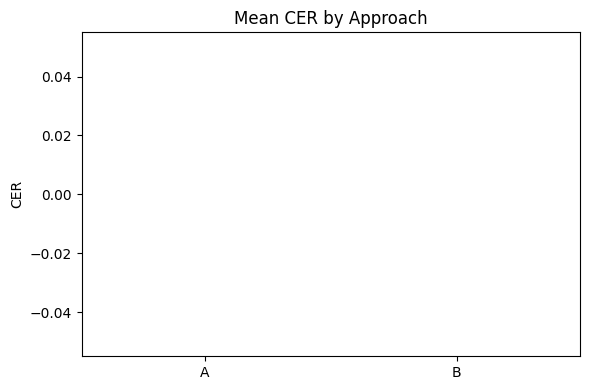

Saved: /content/drive/MyDrive/speech_ai_colab/figures/cer_by_approach.png


In [30]:
# 6.2 — Efficiency metrics
eff_rows = []

# Source duration from preproc wav
def src_wav_for_id(fid):
    return os.path.join(PATHS["inputs"], "preproc", f"{fid}.wav")

for fid in df["id"].astype(str):
    src_wav = src_wav_for_id(fid)
    src_min = wav_duration_sec(src_wav) / 60.0 if os.path.exists(src_wav) else np.nan

    # Manifest times are "last run wins". If you need A vs B separately,
    # we can add a tiny change later; for now this reports what's available.
    asr_t = pd.to_numeric(df.loc[df["id"].astype(str)==fid, "asr_time_s"], errors="coerce").fillna(0).values
    mt_t  = pd.to_numeric(df.loc[df["id"].astype(str)==fid, "mt_time_s"], errors="coerce").fillna(0).values
    tts_t = pd.to_numeric(df.loc[df["id"].astype(str)==fid, "tts_time_s"], errors="coerce").fillna(0).values
    gpu   = pd.to_numeric(df.loc[df["id"].astype(str)==fid, "gpu_mem_peak_mb"], errors="coerce").values

    total_time = float((asr_t[0] if len(asr_t) else 0) + (mt_t[0] if len(mt_t) else 0) + (tts_t[0] if len(tts_t) else 0))
    lpm = (total_time / src_min) if (src_min and not np.isnan(src_min) and src_min > 0) else np.nan

    # Disk footprint by approach
    a_txt = os.path.join(PATHS["outputs"], "approachA", "txt", f"{fid}.txt")
    a_wav = os.path.join(PATHS["outputs"], "approachA", "wav", f"{fid}.wav")
    a_bytes = sum(os.path.getsize(p) for p in (a_txt, a_wav) if os.path.exists(p))

    tgt_wav = str(df.loc[df["id"].astype(str)==fid, "tgt_audio_path"].values[0]) if not df.empty else ""
    tgt_txt = os.path.join(PATHS["outputs"], "approachB", str(df.loc[df["id"].astype(str)==fid, "tgt_lang"].values[0] if not df.empty else "xx"), "tgt_txt", f"{fid}.txt")
    b_bytes = sum(os.path.getsize(p) for p in (tgt_txt, tgt_wav) if isinstance(p, str) and os.path.exists(p))

    eff_rows.append({
        "id": fid,
        "latency_total_s": total_time if total_time > 0 else np.nan,
        "latency_per_min": lpm,
        "peak_vram_mb": float(gpu[0]) if (len(gpu) and not np.isnan(gpu[0])) else np.nan,
        "disk_bytes_A": a_bytes if a_bytes>0 else np.nan,
        "disk_bytes_B": b_bytes if b_bytes>0 else np.nan,
    })

eff_df = pd.DataFrame(eff_rows)
eff_csv = os.path.join(RESULTS_DIR, "efficiency_metrics.csv")
eff_df.to_csv(eff_csv, index=False)
print(f"Wrote {len(eff_df)} rows to {eff_csv}")
display(eff_df.head())

# Simple plots
plt.figure(figsize=(6,4))
m = metrics_df.groupby("approach", as_index=False)["CER"].mean()
plt.bar(m["approach"], m["CER"])
plt.title("Mean CER by Approach")
plt.ylabel("CER")
plt.tight_layout()
fig_path = os.path.join(FIGURES_DIR, "cer_by_approach.png")
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved:", fig_path)

In [32]:
# 6.3 — Subjective MOS (naturalness/pronunciation) — lightweight widget
import ipywidgets as W
from IPython.display import display

MOS_CSV = os.path.join(RESULTS_DIR, "mos_ratings.csv")
mos_rows = []

def rate_one(fid, label, wav_path):
    if not (isinstance(wav_path, str) and os.path.exists(wav_path)):
        print(f"[Skip] Missing audio for {label}: {fid}")
        return
    print(f"\nID: {fid} — {label}")
    display(Audio(filename=wav_path))
    nat = W.IntSlider(description="Naturalness", min=1, max=5, value=4)
    pro = W.IntSlider(description="Pronunciation", min=1, max=5, value=4)
    btn = W.Button(description="Save rating")
    out = W.Output()

    def on_click(_):
        with out:
            mos_rows.append({
                "id": fid,
                "approach": label,
                "naturalness": nat.value,
                "pronunciation": pro.value,
                "timestamp": time.time(),
            })
            print(f"Saved: {fid} {label} N={nat.value} P={pro.value}")

    btn.on_click(on_click)
    display(W.VBox([nat, pro, btn, out]))

# Rate a small subset (adjust ids_to_rate as you like)
ids_to_rate = list(df["id"].astype(str))[:5]
for fid in ids_to_rate:
    a_wav = os.path.join(PATHS["outputs"], "approachA", "wav", f"{fid}.wav")
    b_wav = str(df.loc[df["id"].astype(str)==fid, "tgt_audio_path"].values[0]) if not df.empty else ""
    rate_one(fid, "A", a_wav)
    rate_one(fid, "B", b_wav)

# After rating, run this cell again to write CSV:
if mos_rows:
    mos_df = pd.DataFrame(mos_rows)
    if os.path.exists(MOS_CSV):
        prev = pd.read_csv(MOS_CSV)
        mos_df = pd.concat([prev, mos_df], ignore_index=True)
    mos_df.to_csv(MOS_CSV, index=False)
    print(f"Wrote ratings to {MOS_CSV}")


ID: ar — A



ID: ar — B



ID: zh — A



ID: zh — B



ID: en — A



ID: en — B



ID: de — A



ID: de — B



ID: es — A



ID: es — B


In [25]:
# Cell 6.4- Audio galley comparing Approaches A, B, C
# Prereqs: Run A/B/C first so their WAVs exist. No extra installs needed.
import os, glob

# Resolve PATHS base if not in scope
try:
    PATHS
except NameError:
    BASE = "/content/drive/MyDrive/speech_ai_colab"
    PATHS = {
        "inputs": os.path.join(BASE, "inputs"),
        "outputs": os.path.join(BASE, "outputs"),
        "results": os.path.join(BASE, "results"),
    }

# 0) Config
LIMIT = 5  # how many inputs to include
INPUT_DIR = os.path.join(PATHS["inputs"], "preproc")
CSV_OUT = os.path.join(PATHS["results"], "approach_ABC_summary.csv")

# Optional filters (if set)
TARGET_LANG = globals().get("TARGET_LANG", None)  # e.g., "de"
S2ST_TGT_LANG_M4T = globals().get("S2ST_TGT_LANG_M4T", None)  # e.g., "deu"

# 1) Candidate output locations per approach
A_DIRS = [
    os.path.join(PATHS["outputs"], "approachA", "wav"),
    "/content/drive/MyDrive/approachA_batch_out",  # legacy/batch location if you used it
]

# Discover B tgt_wav folders under PATHS["outputs"]/approachB
B_ROOT = os.path.join(PATHS["outputs"], "approachB")
B_DIRS = []
if os.path.isdir(B_ROOT):
    for root, dirs, files in os.walk(B_ROOT):
        if os.path.basename(root) == "tgt_wav":
            # If TARGET_LANG is set, prefer that lang subdir
            if TARGET_LANG:
                parts = root.split(os.sep)
                try:
                    lang = parts[parts.index("approachB") + 1]
                except Exception:
                    lang = None
                if lang and lang.lower() == str(TARGET_LANG).lower():
                    B_DIRS.append(root)
            else:
                B_DIRS.append(root)

# If nothing matched filter, fall back to any tgt_wav
if not B_DIRS:
    if os.path.isdir(B_ROOT):
        for root, dirs, files in os.walk(B_ROOT):
            if os.path.basename(root) == "tgt_wav":
                B_DIRS.append(root)

# Approach C: support both your batch path and an optional PATHS-based one
C_DIRS = []
if S2ST_TGT_LANG_M4T:
    C_DIRS.append(os.path.join(PATHS["outputs"], "approachC", S2ST_TGT_LANG_M4T))
C_DIRS.append("/content/drive/MyDrive/approachC_batch_out")

def discover_wavs(dirpath, limit=None):
    if not dirpath or not os.path.isdir(dirpath):
        return []
    files = sorted(glob.glob(os.path.join(dirpath, "**", "*.wav"), recursive=True))
    return files[:limit] if (limit and limit > 0) else files

def stem_before_first_dot(filename_no_ext):
    # "audio1.s2st.eng" -> "audio1"
    return filename_no_ext.split(".", 1)[0]

def map_outputs_by_input_stem_multi(dirpaths):
    # Returns: {original_stem: output_path}
    mapping = {}
    for dp in dirpaths:
        if not dp or not os.path.isdir(dp):
            continue
        for p in sorted(glob.glob(os.path.join(dp, "**", "*.wav"), recursive=True)):
            stem = os.path.splitext(os.path.basename(p))[0]
            in_stem = stem_before_first_dot(stem)
            # Only set if not already mapped; earlier dirs in list have priority
            mapping.setdefault(in_stem, p)
    return mapping

def audio_duration_seconds(path):
    try:
        import soundfile as sf
        info = sf.info(path)
        if info.samplerate and info.frames:
            return round(info.frames / float(info.samplerate), 2)
    except Exception:
        pass
    return None

# 2) Collect inputs
inputs = discover_wavs(INPUT_DIR, limit=LIMIT)
if not inputs:
    raise FileNotFoundError(f"No WAV inputs found under {INPUT_DIR}. Verify preprocessing for A/B was completed there.")

# 3) Build output maps
mapA = map_outputs_by_input_stem_multi(A_DIRS)
mapB = map_outputs_by_input_stem_multi(B_DIRS)
mapC = map_outputs_by_input_stem_multi(C_DIRS)

print("Output search dirs:")
print(" - A:", [d for d in A_DIRS if os.path.isdir(d)])
print(" - B:", [d for d in B_DIRS if os.path.isdir(d)])
print(" - C:", [d for d in C_DIRS if os.path.isdir(d)])

# 4) Assemble rows
rows = []
for i, inp in enumerate(inputs, 1):
    base = os.path.splitext(os.path.basename(inp))[0]
    A = mapA.get(base, "")
    B = mapB.get(base, "")
    C = mapC.get(base, "")
    rows.append({
        "idx": i,
        "base": base,
        "input": inp,
        "in_dur_s": audio_duration_seconds(inp),
        "A_out": A,
        "A_dur_s": audio_duration_seconds(A) if A else None,
        "B_out": B,
        "B_dur_s": audio_duration_seconds(B) if B else None,
        "C_out": C,
        "C_dur_s": audio_duration_seconds(C) if C else None,
        "A_missing": not bool(A),
        "B_missing": not bool(B),
        "C_missing": not bool(C),
    })

# 5) Summary table (+ CSV)
have_pandas = True
try:
    import pandas as pd
except Exception:
    have_pandas = False

print(f"\nCollected {len(rows)} input(s). Output folders searched:")
for tag, dirs in (("A", A_DIRS), ("B", B_DIRS), ("C", C_DIRS)):
    existing = [d for d in dirs if os.path.isdir(d)]
    print(f" - {tag}: {existing if existing else '(none found)'}")

if have_pandas:
    df = pd.DataFrame(rows, columns=[
        "idx","base","input","in_dur_s",
        "A_out","A_dur_s","A_missing",
        "B_out","B_dur_s","B_missing",
        "C_out","C_dur_s","C_missing"
    ])
    from IPython.display import display
    display(df)
    if CSV_OUT:
        try:
            os.makedirs(os.path.dirname(CSV_OUT), exist_ok=True)
            df.to_csv(CSV_OUT, index=False)
            print("Saved summary CSV to:", CSV_OUT)
        except Exception as e:
            print("Could not save CSV:", e)
else:
    print("\nSummary:")
    for r in rows:
        print(f"- [{r['idx']}] {r['base']}: in={r['in_dur_s']}s | "
              f"A={r['A_dur_s']}s{' (missing)' if r['A_missing'] else ''} | "
              f"B={r['B_dur_s']}s{' (missing)' if r['B_missing'] else ''} | "
              f"C={r['C_dur_s']}s{' (missing)' if r['C_missing'] else ''}")

# 6) Inline audio preview (Input, A, B, C)
try:
    from IPython.display import Audio, display, HTML
    print("\nAudio preview per input (Input → A → B → C):")
    for r in rows:
        display(HTML(f"<h4>{r['idx']}. {r['base']}</h4>"))
        if os.path.isfile(r["input"]):
            display(HTML(f"<b>Input</b> ({r.get('in_dur_s','?')}s): {os.path.basename(r['input'])}"))
            display(Audio(r["input"], autoplay=False))
        if r["A_out"] and os.path.isfile(r["A_out"]):
            display(HTML(f"<b>Approach A</b> ({r.get('A_dur_s','?')}s): {os.path.basename(r['A_out'])}"))
            display(Audio(r["A_out"], autoplay=False))
        if r["B_out"] and os.path.isfile(r["B_out"]):
            display(HTML(f"<b>Approach B</b> ({r.get('B_dur_s','?')}s): {os.path.basename(r['B_out'])}"))
            display(Audio(r["B_out"], autoplay=False))
        if r["C_out"] and os.path.isfile(r["C_out"]):
            display(HTML(f"<b>Approach C</b> ({r.get('C_dur_s','?')}s): {os.path.basename(r['C_out'])}"))
            display(Audio(r["C_out"], autoplay=False))
        display(HTML("<hr>"))
except Exception:
    print("[Preview] Inline audio not available in this environment.")

print("Done.")

Output search dirs:
 - A: ['/content/drive/MyDrive/speech_ai_colab/outputs/approachA/wav']
 - B: ['/content/drive/MyDrive/speech_ai_colab/outputs/approachB/en/tgt_wav']
 - C: ['/content/drive/MyDrive/approachC_batch_out']

Collected 5 input(s). Output folders searched:
 - A: ['/content/drive/MyDrive/speech_ai_colab/outputs/approachA/wav']
 - B: ['/content/drive/MyDrive/speech_ai_colab/outputs/approachB/en/tgt_wav']
 - C: ['/content/drive/MyDrive/approachC_batch_out']


idx base                                              input  in_dur_s  \
0    1   ar  /content/drive/MyDrive/speech_ai_colab/inputs/...      5.34   
1    2   de  /content/drive/MyDrive/speech_ai_colab/inputs/...      4.29   
2    3   en  /content/drive/MyDrive/speech_ai_colab/inputs/...      4.52   
3    4   es  /content/drive/MyDrive/speech_ai_colab/inputs/...      4.60   
4    5   zh  /content/drive/MyDrive/speech_ai_colab/inputs/...      4.38   

                                               A_out  A_dur_s  A_missing  \
0  /content/drive/MyDrive/speech_ai_colab/outputs...     3.01      False   
1  /content/drive/MyDrive/speech_ai_colab/outputs...     3.52      False   
2  /content/drive/MyDrive/speech_ai_colab/outputs...     2.78      False   
3  /content/drive/MyDrive/speech_ai_colab/outputs...     3.30      False   
4  /content/drive/MyDrive/speech_ai_colab/outputs...     3.20      False   

                                               B_out  B_dur_s  B_missing  \
0  /content/drive/MyDrive/speech_ai_colab/outputs...     4.35      False   
1  /content/drive/MyDrive/speech_ai_colab/outputs...     3.30      False   
2  /content/drive/MyDrive/speech_ai_colab/outputs...     2.85      False   
3  /content/drive/MyDrive/speech_ai_colab/outputs...     3.17      False   
4  /content/drive/MyDrive/speech_ai_colab/outputs...     3.17      False   

                                               C_out  C_dur_s  C_missing  
0  /content/drive/MyDrive/approachC_batch_out/ar....     4.98      False  
1  /content/drive/MyDrive/approachC_batch_out/de....     4.34      False  
2  /content/drive/MyDrive/approachC_batch_out/en....     3.96      False  
3  /content/drive/MyDrive/approachC_batch_out/es....     4.36      False  
4  /content/drive/MyDrive/approachC_batch_out/zh....     4.70      False

Saved summary CSV to: /content/drive/MyDrive/speech_ai_colab/results/approach_ABC_summary.csv

Audio preview per input (Input → A → B → C):


Done.
